In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import pickle
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
from Bio import Entrez
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Добавить drop_duplicate в himorna!!!!!

In [2]:
PWD = Path().cwd()
DATA = Path("../data")
IPS = DATA / "rnaseq_res_ips"
FIBRO = DATA / "rnaseq_res_fibro"
HIMORNA = DATA / "himorna_peaks"
FANTOM = DATA / "fantom_cat"
PREPROCESSING = Path("../preprocessing")
HIMORNA_INDEX = PREPROCESSING / "himorna_index"
HIMORNA_GENES_SIGN =  PREPROCESSING / "himorna_genes_sign"
IPS_INDEX = PREPROCESSING / "ips_deg_index"
FIBRO_INDEX = PREPROCESSING / "fibro_deg_index"
IPS_MATRICES = PREPROCESSING / "ips_matrices"
FIBRO_MATRICES = PREPROCESSING / "fibro_matrices"
IPS_FISHER = PREPROCESSING / "ips_fisher_exact_test"
FIBRO_FISHER = PREPROCESSING / "fibro_fisher_exact_test"
METHYL_BED = PREPROCESSING / "methyl_bed"

IMAGES = PREPROCESSING / "images"

In [3]:
for director in DATA, IPS, FIBRO, PREPROCESSING, HIMORNA_INDEX, HIMORNA_GENES_SIGN, METHYL_BED, IPS_INDEX, FIBRO_INDEX, IPS_MATRICES, FIBRO_MATRICES, IPS_FISHER, FIBRO_FISHER, IMAGES:
    director.mkdir(exist_ok=True, parents=True)

In [20]:
F6_CAT = pd.read_csv(FANTOM / "F6_CAT.gene.info.tsv", sep="\t")

In [21]:
F6_CAT.head()

,geneID,geneName,geneType,CAT_geneClass,cntg,geneStart,geneEnd,strnd,CAT_DHS_type,gapmerID,...,homeodb_ID,cosmic_ID,lncrnadb_ID,mirbase_ID,snornabase_ID,orphanet_ID,pseudogene_org_ID,avg_exonNum,max_exonNum,note
0,CATG00000000002,CATG00000000002.1,__na,coding_mRNA,chr1,1018110,1018979,+,not_DHS,__na,...,__na,__na,__na,__na,__na,__na,__na,1.0,1,__na
1,CATG00000000003,CATG00000000003.1,__na,sense_overlap_RNA,chr1,4661850,4664407,+,not_DHS,__na,...,__na,__na,__na,__na,__na,__na,__na,2.0,2,__na
2,CATG00000000004,CATG00000000004.1,__na,lncRNA_divergent,chr1,46617031,46619604,+,DHS_promoter,__na,...,__na,__na,__na,__na,__na,__na,__na,1.0,1,__na
3,CATG00000000005,CATG00000000005.1,__na,lncRNA_intergenic,chr10,69067991,69068684,-,DHS_enhancer,__na,...,__na,__na,__na,__na,__na,__na,__na,1.0,1,__na
4,CATG00000000006,CATG00000000006.1,__na,lncRNA_divergent,chr10,69069774,69070842,-,not_DHS,__na,...,__na,__na,__na,__na,__na,__na,__na,1.0,1,__na


In [26]:
mask = F6_CAT["geneName"].str.contains("DISP1")
F6_CAT[mask]

,geneID,geneName,geneType,CAT_geneClass,cntg,geneStart,geneEnd,strnd,CAT_DHS_type,gapmerID,...,homeodb_ID,cosmic_ID,lncrnadb_ID,mirbase_ID,snornabase_ID,orphanet_ID,pseudogene_org_ID,avg_exonNum,max_exonNum,note
95390,ENSG00000154309,DISP1,protein_coding,coding_mRNA,chr1,222815048,223011910,+,DHS_promoter,__na,...,__na,DISP1,__na,__na,__na,242325,__na,5.0,12,__na


# Indexing

## himorna peaks

In [31]:
to_peaks = HIMORNA / "Himorna_all.tsv.gz"
himorna_peaks = pd.read_csv(
        to_peaks,
        chunksize=100000000,
        sep="\t",
        usecols=["hm", "lnc", "lnc_ens", "peak", "chrom", "start", "end", "gene", "gene_ens", "corr"]
    )
himorna_peaks = pd.concat(himorna_peaks)
#to_save =  HIMORNA / "Himorna_all.tsv.gz"
#himorna_peaks_all.to_csv(to_save, sep="\t", compression="gzip", index=False)  

In [32]:
himorna_peaks

,hm,lnc,lnc_ens,peak,chrom,start,end,gene,gene_ens,corr
0,H3K27ac,AP005060.1,ENSG00000279885,peak_389211,chr18,10441312,10441530,NaN,NaN,0.500356
1,H3K27ac,AC012409.3,ENSG00000277135,peak_389211,chr18,10441312,10441530,NaN,NaN,0.480105
2,H3K27ac,AC116651.1,ENSG00000273133,peak_389211,chr18,10441312,10441530,NaN,NaN,0.450511
3,H3K27ac,AGAP11,ENSG00000271880,peak_389211,chr18,10441312,10441530,NaN,NaN,0.491645
4,H3K27ac,AC015961.2,ENSG00000267707,peak_389211,chr18,10441312,10441530,NaN,NaN,0.473911
...,...,...,...,...,...,...,...,...,...,...
104264739,H4K20me1,MAPK6-DT,ENSG00000259438,peak_18626,chr1,222815712,222856635,DISP1,ENSG00000154309,-0.730043
104264740,H4K20me1,AL158825.2,ENSG00000229587,peak_18626,chr1,222815712,222856635,NaN,CATG00000036663,-0.755635
104264741,H4K20me1,AL158825.2,ENSG00000229587,peak_18626,chr1,222815712,222856635,NaN,CATG00000095678,-0.755635
104264742,H4K20me1,AL158825.2,ENSG00000229587,peak_18626,chr1,222815712,222856635,NaN,ENSG00000228106,-0.755635


In [59]:
gene_assoc_peaks_area = himorna_peaks.groupby(by="gene_ens").aggregate(
    min_start=("start", "min"),
    max_end=("end", "max"), 
)

In [67]:
gene_assoc_peaks_area["peaks_area"] = gene_assoc_peaks_area["max_end"] - gene_assoc_peaks_area["min_start"]
gene_assoc_peaks_area.sort_values(by="peaks_area", ascending=False, inplace=True)

In [106]:
gene_assoc_peaks_area["peaks_area"].median()

50982.0

<Axes: xlabel='peaks_area'>

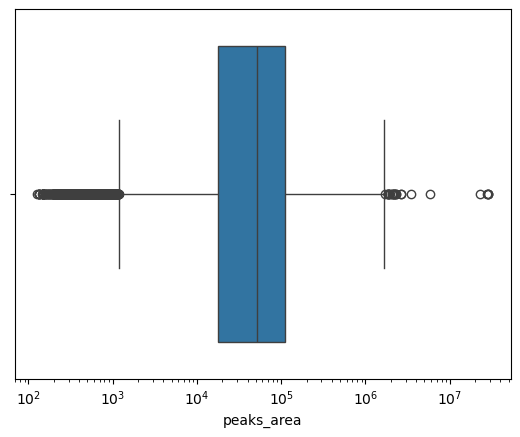

In [121]:
sns.boxplot(x=gene_assoc_peaks_area["peaks_area"], log_scale=True)

<Axes: ylabel='Frequency'>

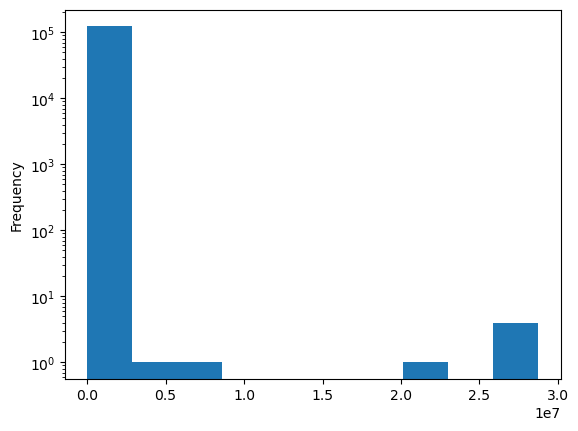

In [81]:
gene_assoc_peaks_area["peaks_area"].plot(kind="hist", logy=True)

(0.0, 600000.0)

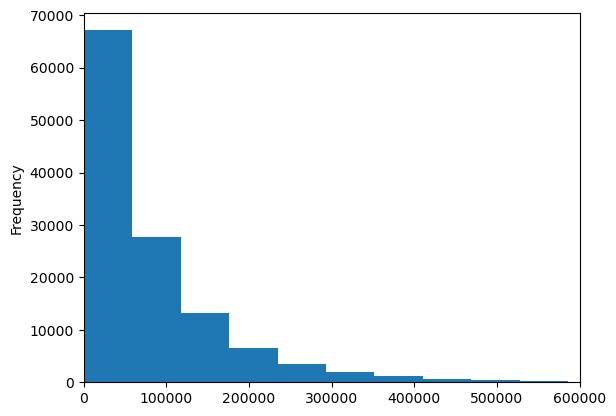

In [119]:
gene_assoc_peaks_area.query("peaks_area >= 0 & peaks_area <= 1*10**7")["peaks_area"].plot(kind="hist", bins=100, logy=False)
plt.xlim(0, 0.6*10**6)

<Axes: ylabel='Frequency'>

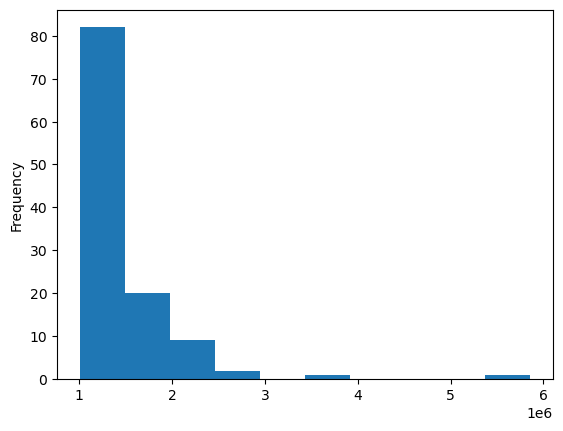

In [89]:
gene_assoc_peaks_area.query("peaks_area >= 0.1*10**7 & peaks_area <= 1*10**7")["peaks_area"].plot(kind="hist", logy=False)

<Axes: ylabel='Frequency'>

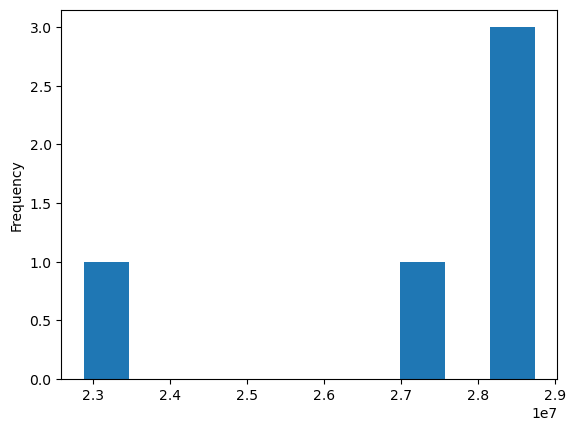

In [79]:
gene_assoc_peaks_area.query("peaks_area >= 2*10**7 & peaks_area <= 3*10**7")["peaks_area"].plot(kind="hist", logy=False)
#plt.xlim(2*10**7, 3*10**7)

In [72]:
gene_assoc_peaks_area.head(100)

,min_start,max_end,peaks_area
gene_ens,,,
ENSG00000269501,120952209,149693030,28740821
ENSG00000215861,120305685,148892511,28586826
CATG00000016100,120175350,148679920,28504570
CATG00000074857,120844116,148255007,27410891
ENSG00000212544,120849771,143729160,22879389
...,...,...,...
CATG00000016402,18507733,19586348,1078615
ENSG00000182890,121019673,122088460,1068787
ENSG00000182667,131313335,132378537,1065202


In [38]:
gene_assoc_count = himorna_peaks.groupby(by="gene_ens").aggregate(
    Число_асоциированных_пиков=("peak", "count")
).sort_values(by="Число_асоциированных_пиков", ascending=False)

In [39]:
gene_assoc_count

,Число_асоциированных_пиков
gene_ens,
ENSG00000183117,97922
ENSG00000269501,87195
CATG00000016100,86359
ENSG00000215861,86023
CATG00000074857,79633
...,...
CATG00000015600,1
CATG00000004674,1
ENSG00000231439,1


In [47]:
cols = ["peak", "chrom", "start", "end"]

In [122]:
ENSG00000160710 = himorna_peaks[himorna_peaks["gene_ens"] == "ENSG00000160710"][cols]

In [124]:
ENSG00000183117["end"].max() - ENSG00000183117["start"].min()

2204406

In [48]:
ENSG00000183117 = himorna_peaks[himorna_peaks["gene_ens"] == "ENSG00000183117"][cols]

In [49]:
ENSG00000183117

,peak,chrom,start,end
1164318,peak_888915,chr8,2944298,2944509
1164319,peak_888915,chr8,2944298,2944509
1164320,peak_888916,chr8,2951265,2951414
1164321,peak_888917,chr8,2958224,2958552
1164322,peak_888917,chr8,2958224,2958552
...,...,...,...,...
104124273,peak_209718,chr8,4891503,4892196
104124275,peak_209719,chr8,4898518,4898748
104124277,peak_209719,chr8,4898518,4898748
104124279,peak_209722,chr8,4920486,4920734


In [52]:
ENSG00000183117["start"].min()

2801817

In [54]:
ENSG00000183117["end"].max()

5006223

In [55]:
5006223 - 2801817

2204406

In [127]:
154628013 - 154581695 #forward strand. #ADAR, GRCh38

46318

In [129]:
154600489 - 154554171 #forward strand. #ADAR, GRCh37

46318

In [5]:
222856635 - 222815712

40923

In [13]:
223005995 - 222815022 #forward strand. #DISP1, GRCh38

190973

In [14]:
223179337 - 222988364 #forward strand. #DISP1, GRCh37

190973

In [42]:
223011910 - 222815048 #forward strand. #DISP1,

196862

In [15]:
223005995 - 222856635 #GRCh38

149360

In [28]:
223179337 - 222856635 #GRCh37

322702

In [29]:
223011910 - 222856635# mazurov

155275

In [6]:
himorna_peaks["gene_ens"].nunique()

123350

In [7]:
himorna_peaks["chrom"].nunique()

134

In [8]:
himorna_peaks["chrom"].unique()

array(['chr18', 'chr2', 'chr14', 'chr21', 'chr16', 'chr11', 'chr1',
       'chr12', 'chr10', 'chr6', 'chrX', 'chr7', 'chr9', 'chr4', 'chr3',
       'chr5', 'chr8', 'chr22', 'chr13', 'chr11_KI270721v1_random',
       'chr22_KI270732v1_random', 'chr22_KI270733v1_random',
       'chr22_KI270734v1_random', 'chr22_KI270735v1_random',
       'chr22_KI270736v1_random', 'chr15', 'chr22_KI270738v1_random',
       'chr2_KI270716v1_random', 'chr14_GL000009v2_random',
       'chr14_GL000194v1_random', 'chr14_GL000225v1_random',
       'chr14_KI270722v1_random', 'chr14_KI270724v1_random',
       'chr14_KI270725v1_random', 'chr14_KI270726v1_random',
       'chr16_KI270728v1_random', 'chr17', 'chr20', 'chrY', 'chr19',
       'chr9_KI270718v1_random', 'chr9_KI270719v1_random', 'chrM',
       'chrUn_GL000195v1', 'chrUn_GL000214v1', 'chrUn_GL000216v2',
       'chrUn_GL000218v1', 'chrUn_GL000219v1', 'chrUn_GL000220v1',
       'chrUn_GL000224v1', 'chrUn_KI270330v1', 'chrUn_KI270333v1',
       'chrUn_KI270

In [9]:
himorna_peaks.shape

(104264744, 10)

In [10]:
himorna_peaks[["lnc", "lnc_ens"]] = himorna_peaks[["lnc", "lnc_ens"]].astype('str')

In [11]:
himorna_peaks = himorna_peaks.drop_duplicates()
himorna_peaks.shape

(104264744, 10)

In [12]:
himorna_peaks = himorna_peaks.dropna(subset=["hm","lnc_ens","gene_ens"])
himorna_peaks.shape

(92208462, 10)

to_peaks = HIMORNA / "Himorna_all_peaks_with_correlations_ensembl_id.tsv.gz"
himorna_peaks_1 = pd.read_csv(
        to_peaks,
        chunksize=100000000,
        sep="\t",
        names=["hm", "lnc", "lnc_ens", "peak", "chrom", "start", "end", "gene", "gene_ens", "corr"]
    )
himorna_peaks_1 = pd.concat(himorna_peaks_1)

In [11]:
himorna_peaks["corr_sign"] = np.where(himorna_peaks["corr"] > 0, "plus", "minus")

In [12]:
himorna_peaks.head()

,hm,lnc,lnc_ens,peak,chrom,start,end,gene,gene_ens,corr,corr_sign
42,H3K27ac,AL353759.1,ENSG00000283064,peak_389220,chr18,10448936,10449130,NaN,CATG00000036918,-0.456836,minus
43,H3K27ac,LINC01876,ENSG00000226383,peak_389220,chr18,10448936,10449130,NaN,CATG00000036918,0.460878,plus
44,H3K27ac,AFDN-DT,ENSG00000198221,peak_389220,chr18,10448936,10449130,NaN,CATG00000036918,0.425995,plus
45,H3K27ac,AL355987.4,ENSG00000273066,peak_389221,chr18,10449168,10449408,NaN,CATG00000036918,0.474245,plus
46,H3K27ac,AC004148.1,ENSG00000263272,peak_389221,chr18,10449168,10449408,NaN,CATG00000036918,-0.481124,minus


In [19]:
ENSG00000238924 = himorna_peaks[himorna_peaks["gene_ens"] == "ENSG00000238924"]

In [20]:
ENSG00000238924["start"].min()

1031916

In [21]:
ENSG00000238924["end"].max()

1133792

In [13]:
list_of_hm = himorna_peaks["hm"].unique()
list_of_hm

array(['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3',
       'H3K79me2', 'H3K9ac', 'H3K9me3', 'H4K20me1'], dtype=object)

In [14]:
himorna_peaks.groupby(by="hm").agg({"peak":pd.Series.nunique, "lnc_ens":pd.Series.nunique, "gene_ens":pd.Series.nunique})

,peak,lnc_ens,gene_ens
hm,,,
H3K27ac,714520,1972,107396
H3K27me3,159597,1342,90277
H3K36me3,268016,1263,100443
H3K4me1,742845,1898,113747
H3K4me2,376694,1002,81821
H3K4me3,610917,1722,98533
H3K79me2,84512,765,62557
H3K9ac,71802,1080,41943
H3K9me3,202237,1035,78459


In [673]:
himorna_peaks["gene_ens"].nunique()

123350

<Axes: >

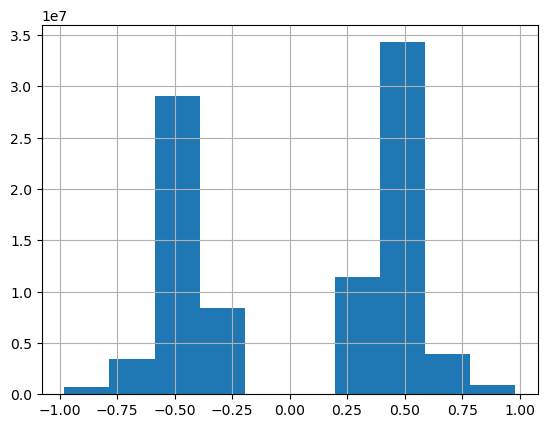

In [15]:
himorna_peaks["corr"].hist()# данные уже отфильтрованы

In [ ]:
def indexing_himorna(hm, lnc_ens, corr_sign, subdf):
    to_index = HIMORNA_INDEX / hm
    to_index.mkdir(exist_ok=True, parents=True)
    to_save = to_index / f"{hm}-{lnc_ens}-{corr_sign}-.tsv.gz"
    if to_save.exists():
        print(f"Skipped: {hm} {lnc_ens} {corr_sign}")
        return None
    subdf.to_csv(to_save, sep="\t", compression="gzip", index=False)

In [ ]:
with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(indexing_himorna)(hm, lnc_ens, corr_sign, subdf)
        for (hm, lnc_ens, corr_sign), subdf in himorna_peaks.groupby(by=["hm", "lnc_ens", "corr_sign"])
    )

In [17]:
#способ смотреть без разбиаения на +/- корреляции
pd.concat([pd.read_csv(to_himorna, sep="\t") for to_himorna in HIMORNA_INDEX.glob((f'*/*-ENSG00000152931-*'))]).head()

,hm,lnc,lnc_ens,peak,chrom,start,end,gene,gene_ens,corr,corr_sign
0,H3K4me1,PART1,ENSG00000152931,peak_492441,chr2,204030106,204032803,NaN,CATG00000046296,0.696499,plus
1,H3K4me1,PART1,ENSG00000152931,peak_492441,chr2,204030106,204032803,NaN,CATG00000051310,0.696499,plus
0,H3K4me3,PART1,ENSG00000152931,peak_136574,chr12,14880482,14886882,C12orf60,ENSG00000182993,0.677999,plus
1,H3K4me3,PART1,ENSG00000152931,peak_250201,chr16,49662975,49664897,ZNF423,ENSG00000102935,0.611509,plus
2,H3K4me3,PART1,ENSG00000152931,peak_264134,chr17,9184690,9185484,NTN1,ENSG00000065320,0.572832,plus


In [889]:
to_himorna = HIMORNA_GENES_SIGN / "H3K27ac/H3K27ac-ENSG00000099869-plus-genes_list-.tsv.gz"
pd.read_csv(to_himorna, sep="\t")

,genes_list
0,ENSG00000253161


In [326]:
def indexing_himorna_genes(hm, lnc_ens):
    df = pd.concat([pd.read_csv(i, sep="\t") for i in HIMORNA_INDEX.glob(f'{hm}/{hm}-{lnc_ens}-*-.tsv.gz')])
    genes_ens_dict = defaultdict(list)
    for gene_ens, subdf in df.groupby(by=["gene_ens"]):
        corr_sign = subdf.value_counts(subset=["corr_sign"]).idxmax()[0]
        genes_ens_dict[corr_sign].append(gene_ens[0])
    
    for corr_sign in genes_ens_dict:
        print(corr_sign)
        to_index = HIMORNA_GENES_SIGN / hm
        to_index.mkdir(exist_ok=True, parents=True)
        to_save = to_index / f"{hm}-{lnc_ens}-{corr_sign}-genes_list-.tsv.gz"
        pd.DataFrame({"genes_list":genes_ens_dict[corr_sign]}).to_csv(to_save, sep="\t", compression="gzip", index=False)

In [323]:
with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(indexing_himorna_genes)(hm, lnc_ens)
        for hm in list_of_hm for lnc_ens in [i.stem.split("-")[1] for i in HIMORNA_INDEX.glob(f'{hm}/{hm}-*-.tsv.gz')]
    )

## fantom ips deg

In [19]:
to_ips = IPS / "EdgeR.table.all.target.tsv.gz"
ips_expr = pd.read_csv(to_ips, sep="\t")
ips_expr.head()

,DEG.geneID,DEG.HGNC,EdgeR.log2FC,EdgeR.log2CPM,EdgeR.pvalue,EdgeR.FDR,EdgeR.Zscore,target.gapmerID,target.geneID,target.HGNC
0,CATG00000000155,CATG00000000155.1,0.257141,3.591144,0.550588,1.0,0.620927,G0234787_01,ENSG00000234787,LINC00458
1,CATG00000001164,CATG00000001164.1,0.706131,3.805757,0.044323,1.0,1.757448,G0234787_01,ENSG00000234787,LINC00458
2,CATG00000001318,CATG00000001318.1,-0.074655,4.766566,0.913694,1.0,0.052701,G0234787_01,ENSG00000234787,LINC00458
3,CATG00000002817,CATG00000002817.1,-0.201767,3.841792,0.716487,1.0,-0.414103,G0234787_01,ENSG00000234787,LINC00458
4,CATG00000003248,CATG00000003248.1,-0.155609,4.592817,0.650460,1.0,0.026003,G0234787_01,ENSG00000234787,LINC00458


In [20]:
ips_expr.shape

(3445156, 10)

In [21]:
ips_expr["DEG.geneID"].unique().shape

(10868,)

ips_expr_filt = ips_expr[(((ips_expr["EdgeR.log2FC"] < 0.5) & (ips_expr["EdgeR.Zscore"] < -1.64)) | 
                                ((ips_expr["EdgeR.log2FC"] > 0.5) & (ips_expr["EdgeR.Zscore"] > 1.64))) & 
                                (ips_expr["EdgeR.FDR"] < 0.05)]
ips_expr_filt.reset_index(inplace=True, drop=True)
ips_expr_filt.head()

ips_expr_filt.shape

In [551]:
ips_expr_filt = ips_expr.query("`EdgeR.FDR` < 0.05 & abs(`EdgeR.Zscore`) > 1.645 & abs(`EdgeR.log2FC`) > 0.5")
ips_expr_filt.reset_index(inplace=True, drop=True)
ips_expr_filt.head()

,DEG.geneID,DEG.HGNC,EdgeR.log2FC,EdgeR.log2CPM,EdgeR.pvalue,EdgeR.FDR,EdgeR.Zscore,target.gapmerID,target.geneID,target.HGNC
0,ENSG00000205531,NAP1L4,-0.691972,7.349218,3.899614e-06,0.042455,-5.061144,G0234787_08,ENSG00000234787,LINC00458
1,ENSG00000089916,GPATCH2L,-1.041246,5.600935,3.913478e-05,0.043336,-3.953852,R0057746_03,CATG00000070943,CATG00000070943.1
2,ENSG00000099194,SCD,-0.635000,8.662415,2.054724e-07,0.000870,-2.709444,R0057746_03,CATG00000070943,CATG00000070943.1
3,ENSG00000113161,HMGCR,-0.912822,6.861125,1.601495e-05,0.029059,-3.682696,R0057746_03,CATG00000070943,CATG00000070943.1
4,ENSG00000128829,EIF2AK4,-0.887877,6.605389,2.397361e-07,0.000870,-4.709886,R0057746_03,CATG00000070943,CATG00000070943.1


In [552]:
ips_expr_filt.shape

(15629, 10)

In [553]:
ips_expr_filt["up_or_down_expr"] = np.where(ips_expr_filt["EdgeR.log2FC"] > 0, "up", "down")

/tmp/ipykernel_19454/601272801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ips_expr_filt["up_or_down_expr"] = np.where(ips_expr_filt["EdgeR.log2FC"] > 0, "up", "down")


<Axes: >

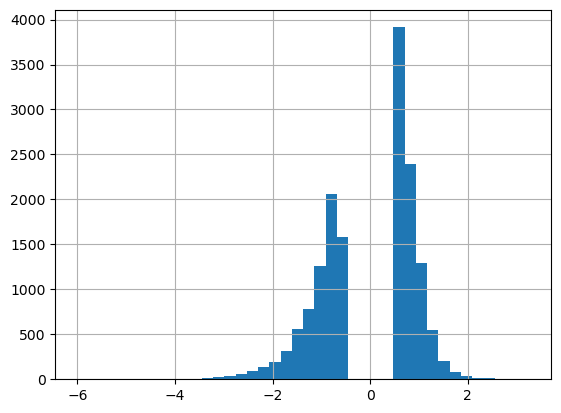

In [554]:
ips_expr_filt["EdgeR.log2FC"].hist(bins=40)

## fantom fibro deg

In [3]:
to_fibro = FIBRO / "DESeq2_genes_ASO_all.tsv.gz"
fibro_expr = pd.read_csv(to_fibro, sep="\t")
fibro_expr.head()

,Description,ASO_CAGE,KD.geneSymbol,perturb_id,geneID,geneSymbol,baseMean,log2FC,pvalue,fdr,KD.tpm.ave,NC.tpm.ave,ZScore
0,Targeted lncRNA,2,A1BG-AS1,ASO_G0268895_01,ENSG00000200169,RNU5D-1,134.656674,-2.325717,1.640034e-11,2.548449e-07,3.026571,15.427402,-3.106205
1,Targeted lncRNA,2,A1BG-AS1,ASO_G0268895_01,ENSG00000138675,FGF5,1788.727654,-1.371879,7.814666e-11,6.071605e-07,75.054256,196.439355,-2.756217
2,Targeted lncRNA,2,A1BG-AS1,ASO_G0268895_01,ENSG00000252521,RNU5D-2P,108.388065,-1.925674,1.102746e-09,5.711854e-06,3.178508,12.249495,-2.534245
3,Targeted lncRNA,2,A1BG-AS1,ASO_G0268895_01,ENSG00000268895,A1BG-AS1,100.134784,-1.542280,3.509193e-09,1.363234e-05,3.802250,11.079833,-7.161737
4,Targeted lncRNA,2,A1BG-AS1,ASO_G0268895_01,CATG00000098831,CATG00000098831.1,163.640506,1.153985,1.174760e-08,3.480974e-05,27.770456,12.658186,2.301412


In [4]:
fibro_expr["geneID"].nunique()

21041

In [5]:
fantom_df = pd.read_csv("../data/fantom_cat/FANTOM_CAT.lv2_permissive.info_table.gene.tsv.gz", sep="\t")

In [7]:
fantom_df["gene_ens"] = fantom_df["geneID"].apply(lambda x: x.split(".")[0])

In [11]:
len(set(fibro_expr["geneID"]) - set(fantom_df["gene_ens"]))

2

In [10]:
len(set(fantom_df["gene_ens"]) - set(fibro_expr["geneID"]))

103206

In [610]:
fibro_expr.shape

(5748772, 13)

In [611]:
fibro_expr_filt = fibro_expr.query("fdr < 0.05 & abs(ZScore) > 1.645 & abs(log2FC) > 0.5")
ips_expr_filt.reset_index(inplace=True, drop=True)
fibro_expr_filt.head()

,Description,ASO_CAGE,KD.geneSymbol,perturb_id,geneID,geneSymbol,baseMean,log2FC,pvalue,fdr,KD.tpm.ave,NC.tpm.ave,ZScore
0,Targeted lncRNA,2,A1BG-AS1,ASO_G0268895_01,ENSG00000200169,RNU5D-1,134.656674,-2.325717,1.640034e-11,2.548449e-07,3.026571,15.427402,-3.106205
1,Targeted lncRNA,2,A1BG-AS1,ASO_G0268895_01,ENSG00000138675,FGF5,1788.727654,-1.371879,7.814666e-11,6.071605e-07,75.054256,196.439355,-2.756217
2,Targeted lncRNA,2,A1BG-AS1,ASO_G0268895_01,ENSG00000252521,RNU5D-2P,108.388065,-1.925674,1.102746e-09,5.711854e-06,3.178508,12.249495,-2.534245
3,Targeted lncRNA,2,A1BG-AS1,ASO_G0268895_01,ENSG00000268895,A1BG-AS1,100.134784,-1.542280,3.509193e-09,1.363234e-05,3.802250,11.079833,-7.161737
4,Targeted lncRNA,2,A1BG-AS1,ASO_G0268895_01,CATG00000098831,CATG00000098831.1,163.640506,1.153985,1.174760e-08,3.480974e-05,27.770456,12.658186,2.301412


In [612]:
fibro_expr_filt.shape

(145540, 13)

In [613]:
fibro_expr_filt["up_or_down_expr"] = np.where(fibro_expr_filt["log2FC"] > 0, "up", "down")

/tmp/ipykernel_19454/515906159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fibro_expr_filt["up_or_down_expr"] = np.where(fibro_expr_filt["log2FC"] > 0, "up", "down")


In [615]:
fibro_expr_filt.rename(columns={"geneID":"DEG.geneID", "perturb_id":"target.gapmerID", "":"target.geneID"}, inplace=True)

/tmp/ipykernel_19454/1739971580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fibro_expr_filt.rename(columns={"geneID":"DEG.geneID", "perturb_id":"target.gapmerID", "":"target.geneID"}, inplace=True)


<Axes: >

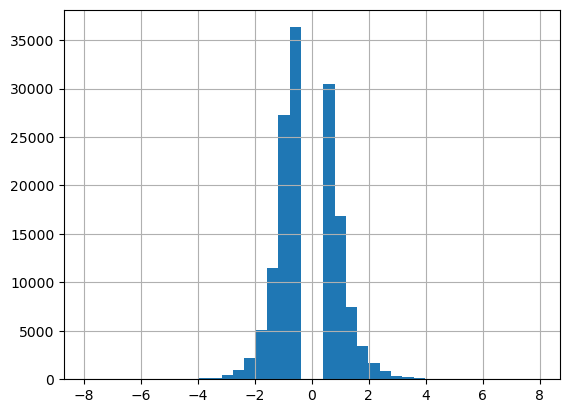

In [616]:
fibro_expr_filt["log2FC"].hist(bins=40)

In [617]:
to_fibro_aso = FIBRO / "ASO_names.info"
fibro_aso = pd.read_csv(to_fibro_aso, sep="\t")
fibro_aso.head()

,aso_id,aso_id_short,prmtrID,prmtrName,trnscptID,trnscptName,trnscptType,geneID,geneName,geneType
0,ASO_C0000830_02,C0000830,CUFT00000000830.T0,chr1_50977446_50977745_+,p012@CDKN2C,CUFT00000000830.T0,__na,ENSG00000123080,CDKN2C,protein_coding
1,ASO_C0000830_08,C0000830,CUFT00000000830.T0,chr1_50977446_50977745_+,p012@CDKN2C,CUFT00000000830.T0,__na,ENSG00000123080,CDKN2C,protein_coding
2,ASO_C0008202_01,C0008202,CUFT00000008202.T0,chr4_183350680_183350979_-,p003@CLDN22,CUFT00000008202.T0,__na,ENSG00000177300,CLDN22,protein_coding
3,ASO_C0008202_02,C0008202,CUFT00000008202.T0,chr4_183350680_183350979_-,p003@CLDN22,CUFT00000008202.T0,__na,ENSG00000177300,CLDN22,protein_coding
4,ASO_C0008202_04,C0008202,CUFT00000008202.T0,chr4_183350680_183350979_-,p003@CLDN22,CUFT00000008202.T0,__na,ENSG00000177300,CLDN22,protein_coding


In [618]:
fibro_aso.rename(columns={"geneID":"target.geneID"}, inplace=True)

In [619]:
fibro_expr_filt = pd.merge(left=fibro_expr_filt, left_on="target.gapmerID",
         right=fibro_aso[["aso_id", "target.geneID"]], right_on="aso_id")
fibro_expr_filt.head()

,Description,ASO_CAGE,KD.geneSymbol,target.gapmerID,DEG.geneID,geneSymbol,baseMean,log2FC,pvalue,fdr,KD.tpm.ave,NC.tpm.ave,ZScore,up_or_down_expr,aso_id,target.geneID
0,Targeted lncRNA,2,A1BG-AS1,ASO_G0268895_01,ENSG00000200169,RNU5D-1,134.656674,-2.325717,1.640034e-11,2.548449e-07,3.026571,15.427402,-3.106205,down,ASO_G0268895_01,ENSG00000268895
1,Targeted lncRNA,2,A1BG-AS1,ASO_G0268895_01,ENSG00000138675,FGF5,1788.727654,-1.371879,7.814666e-11,6.071605e-07,75.054256,196.439355,-2.756217,down,ASO_G0268895_01,ENSG00000268895
2,Targeted lncRNA,2,A1BG-AS1,ASO_G0268895_01,ENSG00000252521,RNU5D-2P,108.388065,-1.925674,1.102746e-09,5.711854e-06,3.178508,12.249495,-2.534245,down,ASO_G0268895_01,ENSG00000268895
3,Targeted lncRNA,2,A1BG-AS1,ASO_G0268895_01,ENSG00000268895,A1BG-AS1,100.134784,-1.542280,3.509193e-09,1.363234e-05,3.802250,11.079833,-7.161737,down,ASO_G0268895_01,ENSG00000268895
4,Targeted lncRNA,2,A1BG-AS1,ASO_G0268895_01,CATG00000098831,CATG00000098831.1,163.640506,1.153985,1.174760e-08,3.480974e-05,27.770456,12.658186,2.301412,up,ASO_G0268895_01,ENSG00000268895


In [621]:
fibro_expr_filt.shape

(141906, 16)

In [622]:
deg_results = {"ips":   ips_expr_filt,
               "fibro": fibro_expr_filt}

In [623]:
def indexing_deg(lnc_ens, aso, up_or_down_expr, subdf, project_dir):
    to_index = Path(project_dir) / lnc_ens
    to_index.mkdir(exist_ok=True, parents=True)
    to_save = to_index / f"{lnc_ens}-{aso}-{up_or_down_expr}-.tsv.gz"
    if to_save.exists():
        print(f"Skipped: {lnc_ens} {aso} {up_or_down_expr} {project_dir.stem}")
        return None
    subdf.to_csv(to_save, sep="\t", compression="gzip", index=False)    

In [624]:
with Parallel(n_jobs=-1) as pool:
        chunks = pool(
            delayed(indexing_deg)(lnc_ens, aso, up_or_down_expr, subdf, project_dir=PREPROCESSING / f"{exp}_deg_index")
            for exp in deg_results
            for (lnc_ens, aso, up_or_down_expr), subdf in deg_results[exp].groupby(by=["target.geneID", "target.gapmerID", "up_or_down_expr"])
        )

In [625]:
#способ смотреть без разбиаения на up/down экспрессию
pd.concat([pd.read_csv(to_deg, sep="\t") for to_deg in IPS_INDEX.glob((f'*/*ENSG00000142396-G0142396_AD_01-*'))]).head()

,DEG.geneID,DEG.HGNC,EdgeR.log2FC,EdgeR.log2CPM,EdgeR.pvalue,EdgeR.FDR,EdgeR.Zscore,target.gapmerID,target.geneID,target.HGNC,up_or_down_expr
0,ENSG00000067113,PLPP1,-0.768020,6.016004,0.000133,0.032065,-2.639597,G0142396_AD_01,ENSG00000142396,ERVK3-1,down
1,ENSG00000071054,MAP4K4,-0.547953,7.187303,0.000127,0.031478,-3.879051,G0142396_AD_01,ENSG00000142396,ERVK3-1,down
2,ENSG00000078140,UBE2K,-0.536019,7.982436,0.000162,0.033866,-3.795072,G0142396_AD_01,ENSG00000142396,ERVK3-1,down
3,ENSG00000101856,PGRMC1,-0.601067,7.721209,0.000080,0.022462,-2.658966,G0142396_AD_01,ENSG00000142396,ERVK3-1,down
4,ENSG00000113269,RNF130,-0.778662,6.261279,0.000012,0.006001,-3.515180,G0142396_AD_01,ENSG00000142396,ERVK3-1,down


In [628]:
#способ смотреть без разбиаения на up/down экспрессию
pd.concat([pd.read_csv(to_deg, sep="\t") for to_deg in FIBRO_INDEX.glob((f'*/*ENSG00000240875-ASO_G0240875_10-*'))]).head()

,Description,ASO_CAGE,KD.geneSymbol,target.gapmerID,DEG.geneID,geneSymbol,baseMean,log2FC,pvalue,fdr,KD.tpm.ave,NC.tpm.ave,ZScore,up_or_down_expr,aso_id,target.geneID
0,Targeted lncRNA,5,LINC00886,ASO_G0240875_10,ENSG00000111144,LTA4H,581.340647,0.643336,5.975901e-10,0.000002,91.036450,58.205364,2.405249,up,ASO_G0240875_10,ENSG00000240875
1,Targeted lncRNA,5,LINC00886,ASO_G0240875_10,ENSG00000197958,RPL12,1002.370844,1.634219,3.039196e-06,0.002936,241.765335,78.679979,2.625141,up,ASO_G0240875_10,ENSG00000240875
2,Targeted lncRNA,5,LINC00886,ASO_G0240875_10,ENSG00000165072,MAMDC2,113.664940,0.786023,3.527888e-06,0.003208,19.069115,11.063988,2.177767,up,ASO_G0240875_10,ENSG00000240875
3,Targeted lncRNA,5,LINC00886,ASO_G0240875_10,ENSG00000137509,PRCP,588.642425,0.528597,4.065014e-06,0.003411,86.973439,60.296739,2.395984,up,ASO_G0240875_10,ENSG00000240875
4,Targeted lncRNA,5,LINC00886,ASO_G0240875_10,ENSG00000104435,STMN2,320.378413,0.519063,1.043377e-05,0.006452,47.048641,32.882947,1.930233,up,ASO_G0240875_10,ENSG00000240875


to_fibro = FIBRO / "DESeq2_genes_ASO_signif.tsv"
fibro_expr_pivot = pd.read_csv(to_fibro, sep="\t")
fibro_expr_pivot.head()

fibro_expr_pivot.shape

fibro_expr = pd.melt(fibro_expr_pivot, 
            id_vars='geneID', 
            value_vars=list(fibro_expr_pivot.columns[2:]), # list of days of the week
            var_name='target.gapmerID', 
            value_name='expr')
fibro_expr.rename(columns={"geneID":"DEG.geneID"}, inplace=True)

fibro_expr.head()

fibro_expr.shape

fibro_expr["DEG.geneID"].nunique()

himorna_peaks["gene_ens"].nunique()

mask = fibro_expr["expr"] == 0
fibro_expr_filt = fibro_expr[~mask]
fibro_expr_filt.head()

fibro_expr_filt.shape

fibro_expr_filt["up_or_down_expr"] = np.where(fibro_expr_filt["expr"] == 1, "up", "down")
fibro_expr_filt = fibro_expr_filt[["DEG.geneID", "target.gapmerID", "target.geneID", "up_or_down_expr"]]

fibro_expr_filt.head()

fibro_expr_filt.shape

with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(indexing_deg)(lnc_ens, aso, up_or_down_expr, subdf, project_dir=FIBRO_INDEX)
        for (lnc_ens, aso, up_or_down_expr), subdf in fibro_expr_filt.groupby(by=["target.geneID", "target.gapmerID", "up_or_down_expr"])
    )

## fantom cat

In [660]:
fantom_lv2 = pd.read_csv(FANTOM / "FANTOM_CAT.lv2_permissive.info_table.gene.tsv.gz", sep="\t")

In [661]:
fantom_lv2.head()

,geneID,loc,strand,geneName,geneClass,geneCategory,DHS_type,geneType,exonLen_bin,splicingType,...,support_source_num,strongest_DPIClstrID,sum_spIndx,max_genomicLen,max_exonLen,TE_LINE_associated,TE_SINE_associated,TE_DNA_associated,TE_LTR_associated,annoComment
0,CATG00000000002.1,"chr1:953490-954359,+",+,CATG00000000002.1,coding_mRNA,__na,not_DHS,__na,bin3:500-1000nt,type1:unspliced,...,2,"chr1:953489..953490,+",0.0,870,870,no,no,no,yes,At least 1 of the 10 top ranked transcript is ...
1,CATG00000000003.1,"chr1:4721910-4724467,+",+,CATG00000000003.1,sense_overlap_RNA,__na,not_DHS,__na,bin5:>2000nt,type2:di-exonic,...,1,"chr1:4721909..4721910,+",0.0,2558,2545,yes,no,no,no,"sense overlapping with another gene, either DP..."
2,CATG00000000004.1,"chr1:47082703-47085276,+",+,CATG00000000004.1,lncRNA_divergent,p_lncRNA_divergent,DHS_promoter,__na,bin4:1000-2000nt,type1:unspliced,...,1,"chr1:47082699..47082703,+",0.0,1542,1542,no,no,no,no,"query_DPI = chr1:47082699..47082703,+;max_hit_..."
3,CATG00000000005.1,"chr10:70827747-70828440,-",-,CATG00000000005.1,lncRNA_intergenic,e_lncRNA,DHS_enhancer,__na,bin3:500-1000nt,type1:unspliced,...,1,"chr10:70828439..70828440,-",0.0,694,694,no,no,no,no,long non-coding RNA and at least 2000 nt from ...
4,CATG00000000006.1,"chr10:70829530-70830598,-",-,CATG00000000006.1,lncRNA_divergent,__na,not_DHS,__na,bin4:1000-2000nt,type1:unspliced,...,1,"chr10:70830593..70830614,-",0.0,1069,1069,no,no,no,no,"query_DPI = chr10:70830593..70830614,-;max_hit..."


In [662]:
fantom_lv4 = pd.read_csv(FANTOM / "FANTOM_CAT.lv4_stringent.info_table.gene.tsv.gz", sep="\t")
fantom_lv3 = pd.read_csv(FANTOM / "FANTOM_CAT.lv3_robust.info_table.gene.tsv.gz", sep="\t")

In [663]:
fantom_lv2["geneID_without_v"] = fantom_lv2["geneID"].apply(lambda x: x.split(".")[0])
fantom_lv3["geneID_without_v"] = fantom_lv3["geneID"].apply(lambda x: x.split(".")[0])
fantom_lv4["geneID_without_v"] = fantom_lv4["geneID"].apply(lambda x: x.split(".")[0])

In [664]:
fantom_lv2_mapping = fantom_lv2[["geneID_without_v", "geneName"]].set_index("geneID_without_v")

In [665]:
fantom_lv2_mapping[fantom_lv2_mapping["geneName"].apply(lambda x: "RP.11" in x)]

,geneName
geneID_without_v,


In [670]:
fantom_lv2.shape[0]

124245

In [671]:
fantom_lv3.shape[0]

59110

In [672]:
fantom_lv4.shape[0]

31520

In [580]:
len(set(himorna_peaks["gene_ens"].unique()) - set(fantom_lv2["geneID_without_v"].unique()))

8

In [581]:
len(set(himorna_peaks["gene_ens"].unique()) - set(fantom_lv3["geneID_without_v"].unique()))

64524

In [582]:
len(set(himorna_peaks["gene_ens"].unique()) - set(fantom_lv4["geneID_without_v"].unique()))

91927

In [583]:
len(set(ips_expr["DEG.geneID"].unique()) - set(fantom_lv2["geneID_without_v"].unique()))

1

In [584]:
len(set(ips_expr["DEG.geneID"].unique())- set(fantom_lv3["geneID_without_v"].unique()))

12

In [585]:
len(set(ips_expr["DEG.geneID"].unique()) - set(fantom_lv4["geneID_without_v"].unique()))

63

In [588]:
len(set(fibro_expr["geneID"].unique()) - set(fantom_lv2["geneID_without_v"].unique()))

2

In [589]:
len(set(fibro_expr["geneID"].unique()) - set(fantom_lv3["geneID_without_v"].unique()))

353

In [590]:
len(set(fibro_expr["geneID"].unique()) - set(fantom_lv4["geneID_without_v"].unique()))

1942

## matrix

In [630]:
def create_matrix(to_deg, to_himorna, exp):
    hm = to_himorna.parent.stem
    ens_gene = to_himorna.stem.split("-")[1]
    
    corr_gene_ids = np.asarray(pd.read_csv([i for i in HIMORNA_GENES_SIGN.glob(f'{hm}/{hm}-{ens_gene}-*.tsv.gz')][0], sep="\t")["genes_list"].unique())
    #corr_gene_ids = np.asarray(pd.read_csv(to_himorna, sep="\t", usecols=["gene_ens"])["gene_ens"].unique())
    deg_gene_ids = np.asarray(pd.read_csv(to_deg, sep="\t", usecols=["DEG.geneID"])["DEG.geneID"].unique())
    
    deg_mask = fantom_lv2["geneID_without_v"].isin(deg_gene_ids)
    corr_mask = fantom_lv2["geneID_without_v"].isin(corr_gene_ids)
    TP = deg_mask & corr_mask
    TN = deg_mask & ~corr_mask
    FP = ~deg_mask & corr_mask
    FN = ~(deg_mask | corr_mask)
    
    to_save = PREPROCESSING / f"{exp}_matrices" / to_himorna.name.split('-')[0] / f"{to_himorna.name.split('-')[1]}-{to_deg.name.split('-')[1]}-{to_himorna.name.split('-')[2]}-{to_deg.name.split('-')[2]}-.npy"
    if to_save.exists():
        print(f"Skipped: ({to_himorna.name.split('-')[0]}) {to_himorna.name.split('-')[1]} {to_deg.name.split('-')[1]} {to_himorna.name.split('-')[2]} {to_deg.name.split('-')[2]}")
        return None
    to_save.parent.mkdir(exist_ok=True, parents=True)
    np.save(to_save, np.stack((TP, TN, FP, FN)))

In [631]:
with Parallel(n_jobs=-1) as pool:
        chunks = pool(
            delayed(create_matrix)(to_deg, to_himorna, exp)
            for exp in ["fibro", "ips"]
            for to_deg in (PREPROCESSING / f"{exp}_deg_index").glob(('*/*.tsv.gz'))
            for corr_sign in ("plus", "minus")
            for to_himorna in HIMORNA_GENES_SIGN.glob(f'*/*-{to_deg.name.split("-")[0]}-{corr_sign}*-.tsv.gz')
        )

In [1073]:
test = []
for to_deg in (PREPROCESSING / f"fibro_deg_index").glob(('*/*.tsv.gz')):
    for corr_sign in ("plus", "minus"):
        for to_himorna in HIMORNA_GENES_SIGN.glob(f'*/*-{to_deg.name.split("-")[0]}-{corr_sign}*-.tsv.gz'):
            test.append(to_himorna)

KeyboardInterrupt: 

In [898]:
len([np.load(to_matrix) for to_matrix in FIBRO_MATRICES.glob("*/*ENSG00000163364-ASO_G0163364_06-minus-down*")])

10

In [1079]:
len(set(["-".join(to_matrix.stem.split("-")[0:1]) for to_matrix in FIBRO_MATRICES.glob("*/*")]))

101

In [1080]:
len(set(["-".join(to_matrix.stem.split("-")[0:2]) for to_matrix in FIBRO_INDEX.glob("*/*")]))

303

In [1081]:
len(set(["-".join(to_matrix.stem.split("-")[0:1]) for to_matrix in FIBRO_INDEX.glob("*/*")]) & set(himorna_peaks["lnc_ens"].unique()))

101

In [1017]:
def number_of_plus_minus_genes(hm, lnc):
    subdf_list = []
    for to_subdf in HIMORNA_GENES_SIGN.glob(f"{hm}/{hm}-{lnc}*"):
        subdf = pd.read_csv(to_subdf)
        subdf["sign"] = [to_subdf.stem.split("-")[2] for i in range(len(subdf))]
        subdf_list.append(subdf)
    subdf = pd.concat(subdf_list)
    plus = len(subdf[subdf["sign"] == "plus"])
    minus = len(subdf[subdf["sign"] == "minus"])
    return (plus, minus)

In [1120]:
def number_of_up_down_genes(lnc, aso, exp):
    subdf_list = []
    for to_subdf in PREPROCESSING.joinpath(f"{exp}_deg_index").glob(f"{lnc}/{lnc}-{aso}*"):
        subdf = pd.read_csv(to_subdf, sep="\t")
        subdf_list.append(subdf)
    subdf = pd.concat(subdf_list)
    up = len(subdf[subdf["up_or_down_expr"] == "up"])
    down = len(subdf[subdf["up_or_down_expr"] == "down"])
    return (up, down)

In [1102]:
number_of_plus_minus_genes("H3K27ac", "ENSG00000163364")

(15, 11)

In [1089]:
number_of_up_down_genes("ENSG00000163364", "ASO_G0163364_06")

(0, 21)

In [1100]:
np.load(FIBRO_MATRICES / "H3K27ac" / "ENSG00000163364-ASO_G0163364_06-minus-down-.npy").sum(axis=1)

array([     0,     21,     15, 124209])

In [1027]:
lnc="CATG00000016989"
aso="ASO_C0020443_06"
#pd.concat([pd.read_csv(to_subdf) for to_subdf in FIBRO_INDEX.glob(f"{lnc}/{lnc}-{aso}*")])
number_of_up_down_genes(lnc, aso)

(12, 60)

In [1110]:
agg_info_by_hm = defaultdict(list)
for to_matrix in FIBRO_MATRICES.glob("H3K27ac/*"):
    print(to_matrix)
    hm, lnc, aso, corr, expr =  to_matrix.parent.stem, to_matrix.stem.split("-")[0], to_matrix.stem.split("-")[1], to_matrix.stem.split("-")[2], to_matrix.stem.split("-")[3]
    matrix = np.load(to_matrix)
    TP = fantom_lv2[matrix[0]].shape[0]#deg_mask & corr_mask
    TN = fantom_lv2[matrix[1]].shape[0]#deg_mask & ~corr_mask
    FP = fantom_lv2[matrix[2]].shape[0]#~deg_mask & corr_mask
    FN = fantom_lv2[matrix[3]].shape[0]#~(deg_mask | corr_mask)
    
    up, down = number_of_up_down_genes(lnc=lnc, aso=aso)
    plus, minus = number_of_plus_minus_genes(hm=hm, lnc=lnc)

    expr_dict = {"up":up, "down":down}
    corr_dict = {"plus":plus, "minus":minus}
    
    agg_info_by_hm["hm"].append(hm)
    agg_info_by_hm["lnc"].append(lnc)
    agg_info_by_hm["aso"].append(aso)
    agg_info_by_hm["expr"].append(expr)
    agg_info_by_hm['corr'].append(corr)
    agg_info_by_hm["number_of_DEG"].append(expr_dict[expr])
    agg_info_by_hm["number_genes_from_himorna"].append(corr_dict[corr])

    agg_info_by_hm["TP"].append(TP)
    agg_info_by_hm["TN"].append(TN)
    agg_info_by_hm["FP"].append(FP)
    agg_info_by_hm["FN"].append(FN)

../preprocessing/fibro_matrices/H3K27ac/ENSG00000214548-ASO_G0214548_01-minus-down-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000229847-ASO_G0229847_01-plus-down-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000223485-ASO_G0223485_01-plus-down-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000223485-ASO_G0223485_AD_06-minus-up-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000186615-ASO_G0186615_04-minus-up-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000234608-ASO_G0234608_AD_04-plus-up-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000227036-ASO_G0227036_AD_07-plus-up-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000229847-ASO_G0229847_AD_02-plus-down-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000221817-ASO_G0221817_04-minus-down-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000229847-ASO_G0229847_01-plus-up-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000263753-ASO_G0263753_AD_06-plus-down-.npy
../preprocessing/fibro_matrices/H3

KeyboardInterrupt: 

In [1112]:
FIBRO_MATRICES

PosixPath('../preprocessing/fibro_matrices')

In [1121]:
def job(hm, exp):
    agg_info_by_hm = defaultdict(list)
    for to_matrix in PREPROCESSING.joinpath(f"{exp}_matrices").glob(f"{hm}/*"):
        hm, lnc, aso, corr, expr =  to_matrix.parent.stem, to_matrix.stem.split("-")[0], to_matrix.stem.split("-")[1], to_matrix.stem.split("-")[2], to_matrix.stem.split("-")[3]
        matrix = np.load(to_matrix)
        TP = fantom_lv2[matrix[0]].shape[0]#deg_mask & corr_mask
        TN = fantom_lv2[matrix[1]].shape[0]#deg_mask & ~corr_mask
        FP = fantom_lv2[matrix[2]].shape[0]#~deg_mask & corr_mask
        FN = fantom_lv2[matrix[3]].shape[0]#~(deg_mask | corr_mask)
        
        up, down = number_of_up_down_genes(lnc=lnc, aso=aso, exp=exp)
        plus, minus = number_of_plus_minus_genes(hm=hm, lnc=lnc)
    
        expr_dict = {"up":up, "down":down}
        corr_dict = {"plus":plus, "minus":minus}
        
        agg_info_by_hm["hm"].append(hm)
        agg_info_by_hm["lnc"].append(lnc)
        agg_info_by_hm["aso"].append(aso)
        agg_info_by_hm["expr"].append(expr)
        agg_info_by_hm['corr'].append(corr)
        agg_info_by_hm["number_of_DEG"].append(expr_dict[expr])
        agg_info_by_hm["number_genes_from_himorna"].append(corr_dict[corr])
    
        agg_info_by_hm["TP"].append(TP)
        agg_info_by_hm["TN"].append(TN)
        agg_info_by_hm["FP"].append(FP)
        agg_info_by_hm["FN"].append(FN)
    df = pd.DataFrame(agg_info_by_hm).sort_values(by="aso")
    to_save = PREPROCESSING / f"{exp}_info"  / f"{hm}.tsv"
    if to_save.exists():
        print(f"Skipped: {exp} {hm}")
        return
    to_save.parent.mkdir(exist_ok=True, parents=True)
    df.to_csv(to_save, sep="\t", index=False)

In [1119]:
for exp in ["fibro", "ips"]:
    print(exp)
    for hm in list_of_hm:
        print(hm)
        job(hm=hm, exp=exp)

fibro
H3K27ac
Skipped: fibro H3K27ac
H3K27me3
H3K36me3
H3K4me1
H3K4me2
H3K4me3


KeyboardInterrupt: 

In [1122]:
with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(job)(hm=hm, exp=exp)
        for exp in ["fibro", "ips"]
        for hm in list_of_hm)

Skipped: fibro H3K36me3
Skipped: fibro H3K4me2
Skipped: fibro H3K27me3
Skipped: fibro H3K4me1
Skipped: fibro H3K27ac


In [1128]:
#проверка
to_csv= PREPROCESSING / "fibro_info"  / "H4K20me1.tsv"
pd.read_csv(to_csv, sep="\t").query("aso == 'ASO_G0163364_06'")

,hm,lnc,aso,expr,corr,number_of_DEG,number_genes_from_himorna,TP,TN,FP,FN
0,H4K20me1,ENSG00000163364,ASO_G0163364_06,down,minus,21,33,0,21,24,124200
1,H4K20me1,ENSG00000163364,ASO_G0163364_06,down,plus,21,24,0,21,24,124200


In [1136]:
pd.concat([pd.read_csv(to_deg, sep="\t") for to_deg in FIBRO_INDEX.glob((f'*/*ENSG00000163364-ASO_G0163364_06-up*'))]).shape

ValueError: No objects to concatenate

In [1137]:
pd.concat([pd.read_csv(to_deg, sep="\t") for to_deg in FIBRO_INDEX.glob((f'*/*ENSG00000163364-ASO_G0163364_06-down*'))]).shape

(21, 16)

In [1132]:
pd.concat([pd.read_csv(to_himorna, sep="\t") for to_himorna in HIMORNA_GENES_SIGN.glob((f'H4K20me1/*-ENSG00000163364-plus*'))]).shape

(24, 1)

In [1133]:
pd.concat([pd.read_csv(to_himorna, sep="\t") for to_himorna in HIMORNA_GENES_SIGN.glob((f'H4K20me1/*-ENSG00000163364-minus*'))]).shape

(33, 1)

In [1143]:
matrix = [np.load(to_matrix) for to_matrix in FIBRO_MATRICES.glob("H4K20me1/*ENSG00000163364-ASO_G0163364_06-minus-down*")][0]
print(fantom_lv2[matrix[0]].shape[0], fantom_lv2[matrix[1]].shape[0],
      fantom_lv2[matrix[2]].shape[0], fantom_lv2[matrix[3]].shape[0])

0 21 24 124200


In [1114]:
agg_info_func(hm="H3K27ac", exp="fibro")

../preprocessing/fibro_matrices/H3K27ac/ENSG00000214548-ASO_G0214548_01-minus-down-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000229847-ASO_G0229847_01-plus-down-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000223485-ASO_G0223485_01-plus-down-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000223485-ASO_G0223485_AD_06-minus-up-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000186615-ASO_G0186615_04-minus-up-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000234608-ASO_G0234608_AD_04-plus-up-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000227036-ASO_G0227036_AD_07-plus-up-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000229847-ASO_G0229847_AD_02-plus-down-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000221817-ASO_G0221817_04-minus-down-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000229847-ASO_G0229847_01-plus-up-.npy
../preprocessing/fibro_matrices/H3K27ac/ENSG00000263753-ASO_G0263753_AD_06-plus-down-.npy
../preprocessing/fibro_matrices/H3

In [1088]:
[pd.read_csv(to_matrix, sep="\t") for to_matrix in FIBRO_FISHER.glob("*.tsv")][0]

,hm,lnc_ens,aso,minus_down,minus_up,plus_down,plus_up,p_value_md_adj,p_value_mu_adj,p_value_pd_adj,p_value_pu_adj
0,H4K20me1,ENSG00000163364,ASO_G0163364_06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,H4K20me1,ENSG00000163364,ASO_G0163364_AD_01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,H4K20me1,ENSG00000204054,ASO_G0204054_01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,H4K20me1,ENSG00000204054,ASO_G0204054_06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,H4K20me1,ENSG00000204054,ASO_G0204054_10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
79,H4K20me1,ENSG00000272269,ASO_G0272269_06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
80,H4K20me1,ENSG00000272888,ASO_G0272888_AD_07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
81,H4K20me1,ENSG00000272888,ASO_G0272888_AD_10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
82,H4K20me1,ENSG00000273015,ASO_G0273015_05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [1055]:
len(set(["-".join(to_matrix.stem.split("-")[0:2]) for to_matrix in FIBRO_INDEX.glob("*/*")]))

303

In [1083]:
len(set(["-".join(to_matrix.stem.split("-")[0:2]) for to_matrix in FIBRO_MATRICES.glob("*/*")]))

209

In [1037]:
deg_results["fibro"]["aso_id"].nunique()

303

In [1048]:
deg_results["fibro"]["lnc_aso"] = (deg_results["fibro"]["target.geneID"] + "-" + deg_results["fibro"]["aso_id"])

In [1053]:
set(deg_results["fibro"]["lnc_aso"].unique()) - set(["-".join(to_matrix.stem.split("-")[0:2]) for to_matrix in FIBRO_MATRICES.glob("*/*")])

{'CATG00000016989-ASO_C0020443_06',
 'CATG00000017883-ASO_C0020672_01',
 'CATG00000017883-ASO_C0020672_02',
 'CATG00000017883-ASO_C0020672_07',
 'CATG00000020700-ASO_C0020984_02',
 'CATG00000020700-ASO_C0020984_09',
 'CATG00000079799-ASO_C0008586_03',
 'CATG00000089639-ASO_G0223811_04',
 'CATG00000098831-ASO_C0013510_06',
 'ENSG00000106546-ASO_C0011632_03',
 'ENSG00000106546-ASO_C0011632_10',
 'ENSG00000106546-ASO_C0011632_AD_03',
 'ENSG00000123080-ASO_C0000830_02',
 'ENSG00000123080-ASO_C0000830_08',
 'ENSG00000142396-ASO_G0142396_AD_01',
 'ENSG00000142396-ASO_G0142396_AD_07',
 'ENSG00000143429-ASO_G0143429_05',
 'ENSG00000172262-ASO_C0008543_05',
 'ENSG00000177300-ASO_C0008202_01',
 'ENSG00000177300-ASO_C0008202_02',
 'ENSG00000177300-ASO_C0008202_04',
 'ENSG00000183850-ASO_G0267886_03',
 'ENSG00000183850-ASO_G0267886_AD_02',
 'ENSG00000183850-ASO_G0267886_AD_04',
 'ENSG00000188070-ASO_G0188070_AD_05',
 'ENSG00000203739-ASO_G0203739_10',
 'ENSG00000203739-ASO_G0203739_AD_03',
 'ENSG0

In [1054]:
set(["-".join(to_matrix.stem.split("-")[0:2]) for to_matrix in FIBRO_MATRICES.glob("*/*")]) - set(deg_results["fibro"]["lnc_aso"].unique())

set()

In [1039]:
set(set(["-".join(to_matrix.stem.split("-")[0:2]) for to_matrix in FIBRO_MATRICES.glob("*/*")])) - set(deg_results["fibro"]["aso_id"].unique())

{'ENSG00000163364-ASO_G0163364_06',
 'ENSG00000163364-ASO_G0163364_AD_01',
 'ENSG00000180769-ASO_G0180769_03',
 'ENSG00000180769-ASO_G0180769_08',
 'ENSG00000180769-ASO_G0180769_AD_03',
 'ENSG00000182165-ASO_G0182165_AD_04',
 'ENSG00000182165-ASO_G0182165_AD_08',
 'ENSG00000182165-ASO_G0182165_AD_10',
 'ENSG00000186615-ASO_G0186615_03',
 'ENSG00000186615-ASO_G0186615_04',
 'ENSG00000203706-ASO_G0203706_01',
 'ENSG00000203721-ASO_G0203721_02',
 'ENSG00000203721-ASO_G0203721_05',
 'ENSG00000204054-ASO_G0204054_01',
 'ENSG00000204054-ASO_G0204054_06',
 'ENSG00000204054-ASO_G0204054_10',
 'ENSG00000205181-ASO_G0205181_01',
 'ENSG00000212978-ASO_G0212978_01',
 'ENSG00000212978-ASO_G0212978_02',
 'ENSG00000212978-ASO_G0212978_03',
 'ENSG00000214548-ASO_G0214548_01',
 'ENSG00000214548-ASO_G0214548_AD_09',
 'ENSG00000215039-ASO_G0215039_01',
 'ENSG00000218510-ASO_G0218510_04',
 'ENSG00000218510-ASO_G0218510_AD_03',
 'ENSG00000218510-ASO_G0218510_AD_06',
 'ENSG00000219665-ASO_G0219665_AD_04',
 

In [945]:
himorna_peaks["lnc_ens"].nunique()

4040

In [946]:
lnc_rna = set([i.stem.split("-")[1] for i in HIMORNA_GENES_SIGN.glob(f"*/*.tsv.gz")])
len(lnc_rna)

4040

In [971]:
subdf_list = []
for to_subdf in HIMORNA_GENES_SIGN.glob(f"{hm}/{hm}-{lnc}*"):
    subdf = pd.read_csv(to_subdf)
    subdf["sign"] = [to_subdf.stem.split("-")[2] for i in range(len(subdf))]
    subdf_list.append(subdf)
pd.concat(subdf_list)

,genes_list,sign
0,CATG00000002476,plus
1,CATG00000019960,plus
2,CATG00000021899,plus
3,CATG00000041857,plus
4,CATG00000047650,plus
5,CATG00000047653,plus
6,CATG00000049907,plus
7,CATG00000060229,plus
8,CATG00000064696,plus
9,CATG00000115696,plus


In [980]:
for hm in list_of_hm:
    for lnc in lnc_rna:
        subdf_list = []
        for to_subdf in HIMORNA_GENES_SIGN.glob(f"{hm}/{hm}-{lnc}*"):
            subdf = pd.read_csv(to_subdf)
            subdf["sign"] = [to_subdf.stem.split("-")[2] for i in range(len(subdf))]
            subdf_list.append(subdf)
        subdf = pd.concat(subdf_list)
        minus = len(subdf[subdf["sign"] == "minus"])
        plus = len(subdf[subdf["sign"] == "plus"])
        break
    break

In [982]:
lnc

'ENSG00000270127'

In [995]:
number_of_plus_minus_genes("H3K27ac", "ENSG00000270127")

(15, 11)

In [977]:
plus

15

In [974]:
t

sign 
plus     15
minus    11
Name: count, dtype: int64

## fisher exact test

In [632]:
def fisher_exact_test(to_matrice):
    matrice = np.sum(np.load(to_matrice), axis=1)
    fisher_exact_res = fisher_exact([[matrice[0], matrice[1]], 
                         [matrice[2], matrice[3]]], alternative='two-sided')
    return fisher_exact_res[1]
    #return matrice

In [634]:
{to_himorna.stem:pd.read_csv(to_himorna, sep="\t").drop_duplicates(subset=["hm", "lnc_ens", "gene_ens"]).shape[0] for to_himorna in HIMORNA_INDEX.glob(f'H3K27ac/*-ENSG00000229852-*')}

{'H3K27ac-ENSG00000229852-plus-.tsv': 1326,
 'H3K27ac-ENSG00000229852-minus-.tsv': 994}

На один ген может приходиться много пиков

In [635]:
#старая версия
check = {to_himorna.stem:pd.read_csv(to_himorna, sep="\t").drop_duplicates(subset=["hm", "lnc_ens", "gene_ens"]) for to_himorna in HIMORNA_INDEX.glob(f'H3K27ac/*-ENSG00000229852-*')}

In [636]:
{i:(check[i]["gene_ens"] == "CATG00000066324").sum() for i in check}

{'H3K27ac-ENSG00000229852-plus-.tsv': 1,
 'H3K27ac-ENSG00000229852-minus-.tsv': 1}

In [637]:
#новая, исправленная версия
check = {to_himorna.stem:pd.read_csv(to_himorna, sep="\t") for to_himorna in HIMORNA_GENES_SIGN.glob(f'H3K27ac/*-ENSG00000229852-*')}

In [638]:
{i:(check[i]["genes_list"] == "CATG00000066324").sum() for i in check}

{'H3K27ac-ENSG00000229852-plus-genes_list-.tsv': 1,
 'H3K27ac-ENSG00000229852-minus-genes_list-.tsv': 0}

In [639]:
#Проверка
ttest = himorna_peaks[(himorna_peaks["hm"] == "H3K27ac") & (himorna_peaks["lnc_ens"] == "ENSG00000229852")]
ttest[ttest["gene_ens"] == "CATG00000066324"]
ttest[ttest["gene_ens"] == "CATG00000066324"].value_counts(subset="corr_sign")

corr_sign
plus     5
minus    1
Name: count, dtype: int64

In [640]:
#способ смотреть без разбиаения на up/down экспрессию
{to_deg.stem:pd.read_csv(to_deg, sep="\t").shape[0] for to_deg in FIBRO_INDEX.glob((f'*/*ASO_G0229852_03-*'))}

{'ENSG00000229852-ASO_G0229852_03-up-.tsv': 255,
 'ENSG00000229852-ASO_G0229852_03-down-.tsv': 389}

In [642]:
def reshape_df(df):
    df['combination'] = df['corr_sign'] + '_' + df['up_or_down_expr']
    # Создание сводной таблицы
    pivot_df = df.pivot_table(index=['hm', 'lnc_ens', 'aso'], 
                              columns='combination', 
                              values='p_value', 
                              aggfunc='first').reset_index()
    # Заполнение NaN значений нулями или другими значениями по необходимости
    pivot_df = pivot_df.fillna(1)
    return pivot_df

In [644]:
def job(hm, exp):
    p_values = []
    lncrna = []
    aso = []
    corr_sign = []
    up_or_down_expr = []
    for to_matrice in (PREPROCESSING / f"{exp}_matrices" / hm).glob('*'):
        p_values.append(fisher_exact_test(to_matrice))
        lncrna.append(to_matrice.name.split("-")[0])
        aso.append(to_matrice.name.split("-")[1])
        corr_sign.append(to_matrice.name.split("-")[2])
        up_or_down_expr.append(to_matrice.name.split("-")[3])
    df = pd.DataFrame({"hm": [hm for i in range(len(p_values))],
                       "lnc_ens": lncrna,
                       "aso": aso,
                       "p_value": p_values,
                       "corr_sign": corr_sign,
                       "up_or_down_expr": up_or_down_expr
                      })
    df = reshape_df(df)
    p_value_md_adj_bonf = multipletests(df["minus_down"], method='fdr_bh', alpha=0.05, is_sorted=False, returnsorted=False)[1]
    df['p_value_md_adj'] = p_value_md_adj_bonf

    p_value_mu_adj_bonf = multipletests(df["minus_up"], method='fdr_bh', alpha=0.05, is_sorted=False, returnsorted=False)[1]
    df['p_value_mu_adj'] = p_value_mu_adj_bonf

    p_value_pd_adj_bonf = multipletests(df["plus_down"], method='fdr_bh', alpha=0.05, is_sorted=False, returnsorted=False)[1]
    df['p_value_pd_adj'] = p_value_pd_adj_bonf

    p_value_pu_adj_bonf = multipletests(df["plus_up"], method='fdr_bh', alpha=0.05, is_sorted=False, returnsorted=False)[1]
    df['p_value_pu_adj'] = p_value_pu_adj_bonf
    
    to_save = PREPROCESSING / f"{exp}_fisher_exact_test"  / f"{hm}.tsv"
    if to_save.exists():
        print(f"Skipped: {exp} {hm}")
        return
    to_save.parent.mkdir(exist_ok=True, parents=True)
    df.to_csv(to_save, sep="\t", index=False)

In [645]:
with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(job)(hm=hm, exp=exp)
        for exp in ["fibro", "ips"]
        for hm in list_of_hm)

In [646]:
fisher_results_filt_by_exp = {}
usecols=["hm", "lnc_ens", "aso", "p_value_md_adj", "p_value_mu_adj", "p_value_pd_adj", "p_value_pu_adj"]
for exp in ["fibro", "ips"]:
    fisher_results = [pd.read_csv(to_df, usecols=usecols, sep="\t") for to_df in (PREPROCESSING / f"{exp}_fisher_exact_test").glob("*.tsv")]
    fisher_results = pd.concat(fisher_results).reset_index(drop=True)

    mask = np.where(
        (fisher_results["p_value_md_adj"] < 0.05) |
        (fisher_results["p_value_mu_adj"] < 0.05) |
        (fisher_results["p_value_pd_adj"] < 0.05) |
        (fisher_results["p_value_pu_adj"] < 0.05),
        True,
        False
    )
    fisher_results_filt = fisher_results[mask].rename(columns={"p_value_md_adj":"er", "p_value_mu_adj":"ea", "p_value_pd_adj":"wa", "p_value_pu_adj":"wr"})
    fisher_results_filt["lnc"] = fisher_results_filt["lnc_ens"].apply(lambda x: fantom_lv2_mapping.loc[x, "geneName"])
    fisher_results_filt_by_exp[exp] = fisher_results_filt

In [647]:
fisher_results_filt_by_exp["fibro"]

,hm,lnc_ens,aso,er,ea,wa,wr,lnc
12,H4K20me1,ENSG00000225733,ASO_G0225733_AD_03,9.428572e-04,1.000000e+00,9.428572e-04,1.000000e+00,FGD5-AS1
13,H4K20me1,ENSG00000225733,ASO_G0225733_AD_06,2.566966e-03,1.000000e+00,2.566966e-03,1.000000e+00,FGD5-AS1
31,H4K20me1,ENSG00000233901,ASO_G0233901_05,2.566966e-03,1.000000e+00,2.566966e-03,1.000000e+00,RP11-65J3.1
127,H3K27me3,ENSG00000233396,ASO_G0233396_07,3.227482e-88,2.460891e-15,3.227482e-88,2.460891e-15,RP11-458D21.1
138,H3K27me3,ENSG00000234608,ASO_G0234608_06,1.384337e-70,1.991006e-01,1.384337e-70,1.991006e-01,MAPKAPK5-AS1
...,...,...,...,...,...,...,...,...
946,H3K79me2,ENSG00000240875,ASO_G0240875_03,1.429075e-07,1.116124e-03,1.429075e-07,1.116124e-03,LINC00886
947,H3K79me2,ENSG00000240875,ASO_G0240875_04,7.964055e-03,1.000000e+00,7.964055e-03,1.000000e+00,LINC00886
956,H3K79me2,ENSG00000246430,ASO_G0246430_03,6.331531e-04,2.560905e-01,6.331531e-04,2.560905e-01,LINC00968
966,H3K79me2,ENSG00000256268,ASO_G0256268_AD_03,6.372911e-03,1.000000e+00,6.372911e-03,1.000000e+00,RP11-221N13.3


In [478]:
fisher_results_filt_by_exp["fibro"][fisher_results_filt_by_exp["fibro"]["lnc"] == "A1BG-AS1"]

,hm,lnc_ens,aso,er,ea,wa,wr,lnc
260,H3K36me3,ENSG00000268895,ASO_G0268895_01,1.765239e-13,1.000000e+00,1.765239e-13,1.000000e+00,A1BG-AS1
261,H3K36me3,ENSG00000268895,ASO_G0268895_03,1.220179e-08,9.557497e-06,1.220179e-08,9.557497e-06,A1BG-AS1
493,H3K4me3,ENSG00000268895,ASO_G0268895_03,2.683187e-02,1.000000e+00,1.000000e+00,1.000000e+00,A1BG-AS1
606,H3K27ac,ENSG00000268895,ASO_G0268895_01,9.638031e-27,7.437591e-03,9.638031e-27,7.437591e-03,A1BG-AS1
607,H3K27ac,ENSG00000268895,ASO_G0268895_03,1.689539e-124,1.010549e-12,1.689539e-124,1.010549e-12,A1BG-AS1
885,H3K4me1,ENSG00000268895,ASO_G0268895_03,8.574723e-03,3.419813e-01,8.574723e-03,3.419813e-01,A1BG-AS1


In [649]:
fisher_results_filt_by_exp["fibro"][fisher_results_filt_by_exp["fibro"]["lnc"] == "A1BG-AS1"]

,hm,lnc_ens,aso,er,ea,wa,wr,lnc
260,H3K36me3,ENSG00000268895,ASO_G0268895_01,1.765239e-13,1.000000e+00,1.765239e-13,1.000000e+00,A1BG-AS1
261,H3K36me3,ENSG00000268895,ASO_G0268895_03,1.220179e-08,9.557497e-06,1.220179e-08,9.557497e-06,A1BG-AS1
493,H3K4me3,ENSG00000268895,ASO_G0268895_03,2.683187e-02,1.000000e+00,1.000000e+00,1.000000e+00,A1BG-AS1
606,H3K27ac,ENSG00000268895,ASO_G0268895_01,9.638031e-27,7.437591e-03,9.638031e-27,7.437591e-03,A1BG-AS1
607,H3K27ac,ENSG00000268895,ASO_G0268895_03,1.689539e-124,1.010549e-12,1.689539e-124,1.010549e-12,A1BG-AS1
885,H3K4me1,ENSG00000268895,ASO_G0268895_03,8.574723e-03,3.419813e-01,8.574723e-03,3.419813e-01,A1BG-AS1


## heatmap

In [821]:
x = np.arange(1e-10, 1, 0.01)
y = -np.log10(x)

<Axes: >

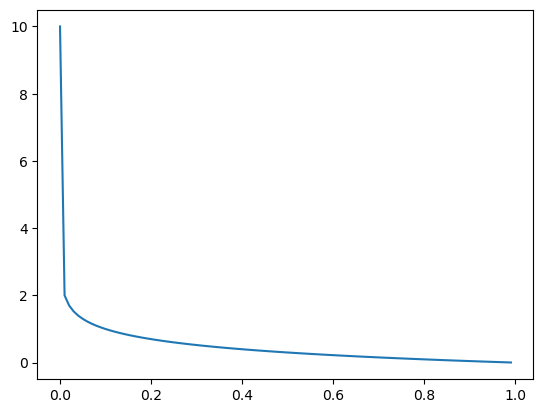

In [822]:
sns.lineplot(x=x, y=y)

https://github.com/vanya-antonov/article-himorna-and-f6/blob/main/src/four_roles.ipynb
pm => wa
1st "p" => positive correlation between lncRNA and the level of a histone mark => lncRNA writes the mark => writer (w)

2nd "m" => after lncRNA knockdown the expression of a nearby gene decreases => in normal cells (i.e. without knockdown) lncRNA upregulates expression of the gene.

Taking into account that lncRNA is writer, the only way it can upregulate gene expression is that it writes an active mark => its molecular role is "Writer of an Active mark (wa)"

pp => wr
1st "p" => positive correlation between lncRNA and the level of a histone mark => lncRNA writes the mark => writer (w)

2nd "p" => after lncRNA knockdown the expression of a nearby gene increases => in normal cells (i.e. without knockdown) lncRNA downregulates expression of the gene.

Taking into account that lncRNA is writer, the only way it can downregulate gene expression is that it writes a repressive mark => its molecular role is "Writer of a Repressive mark (wr)"

mp => ea
1st "m" => negative correlation between lncRNA and the level of a histone mark => lncRNA removes the mark => eraser (e)

2nd "p" => after lncRNA knockdown the expression of a nearby gene increases => in normal cells (i.e. without knockdown) lncRNA downregulates expression of the gene.

Taking into account that lncRNA is eraser, the only way it can downregulate gene expression is that it erases an active mark => its molecular role is "Eraser of an Active mark (ea)"

mm => er
1st "m" => negative correlation between lncRNA and the level of a histone mark => lncRNA removes the mark => eraser (e)

2nd "m" => after lncRNA knockdown the expression of a nearby gene decreases => in normal cells (i.e. without knockdown) lncRNA upregulates expression of the gene.

Taking into account that lncRNA is eraser, the only way it can upregulate gene expression is that it removes repressive mark => its molecular role is "Eraser of a Repressive mark (er)"

In [656]:
def heatmap(df, exp):
    df_for_heatmap = pd.pivot_table(data=df[["hm","lnc","er","ea","wa","wr"]], index=["lnc"], columns="hm", aggfunc="min").map(lambda x: 1 if x <= 0.05 else 0)
    fig, ax = plt.subplots(1, 1, figsize=(15, 12), sharey=True)
    heatmap = sns.heatmap(df_for_heatmap.sort_index(axis=1, level=1), linewidths=.3, cmap='Oranges', annot=False).set_title(f"Heatmap for {exp}")
    ax.set(xlabel="", ylabel="")
    ax.xaxis.tick_top()
    plt.xticks(rotation=90)
    plt.savefig(IMAGES / f"heatmap_{exp}.png")
    plt.show()    

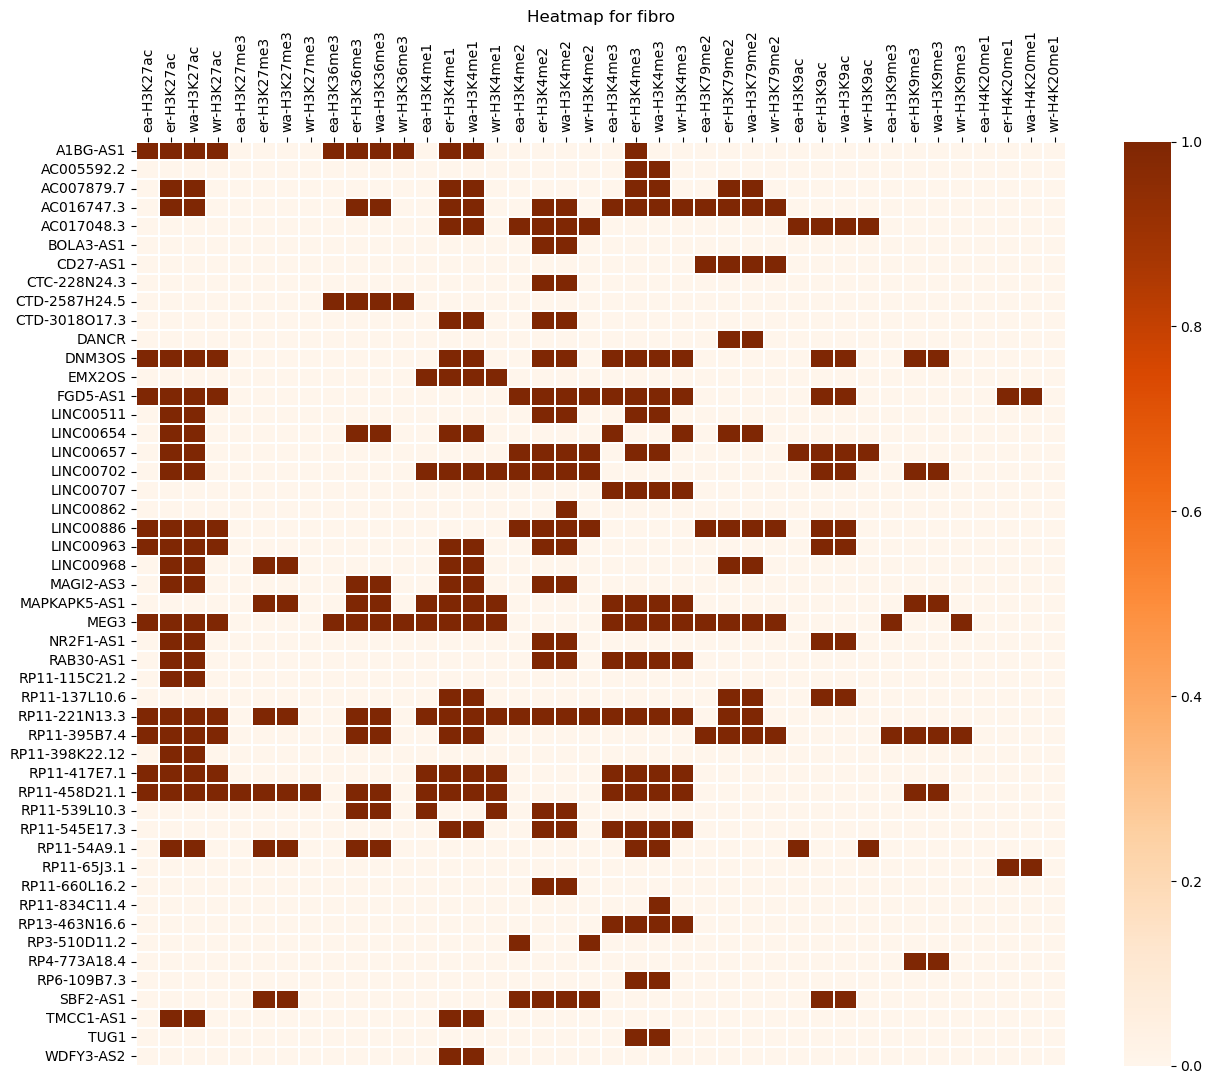

In [657]:
heatmap(fisher_results_filt_by_exp["fibro"], "fibro")

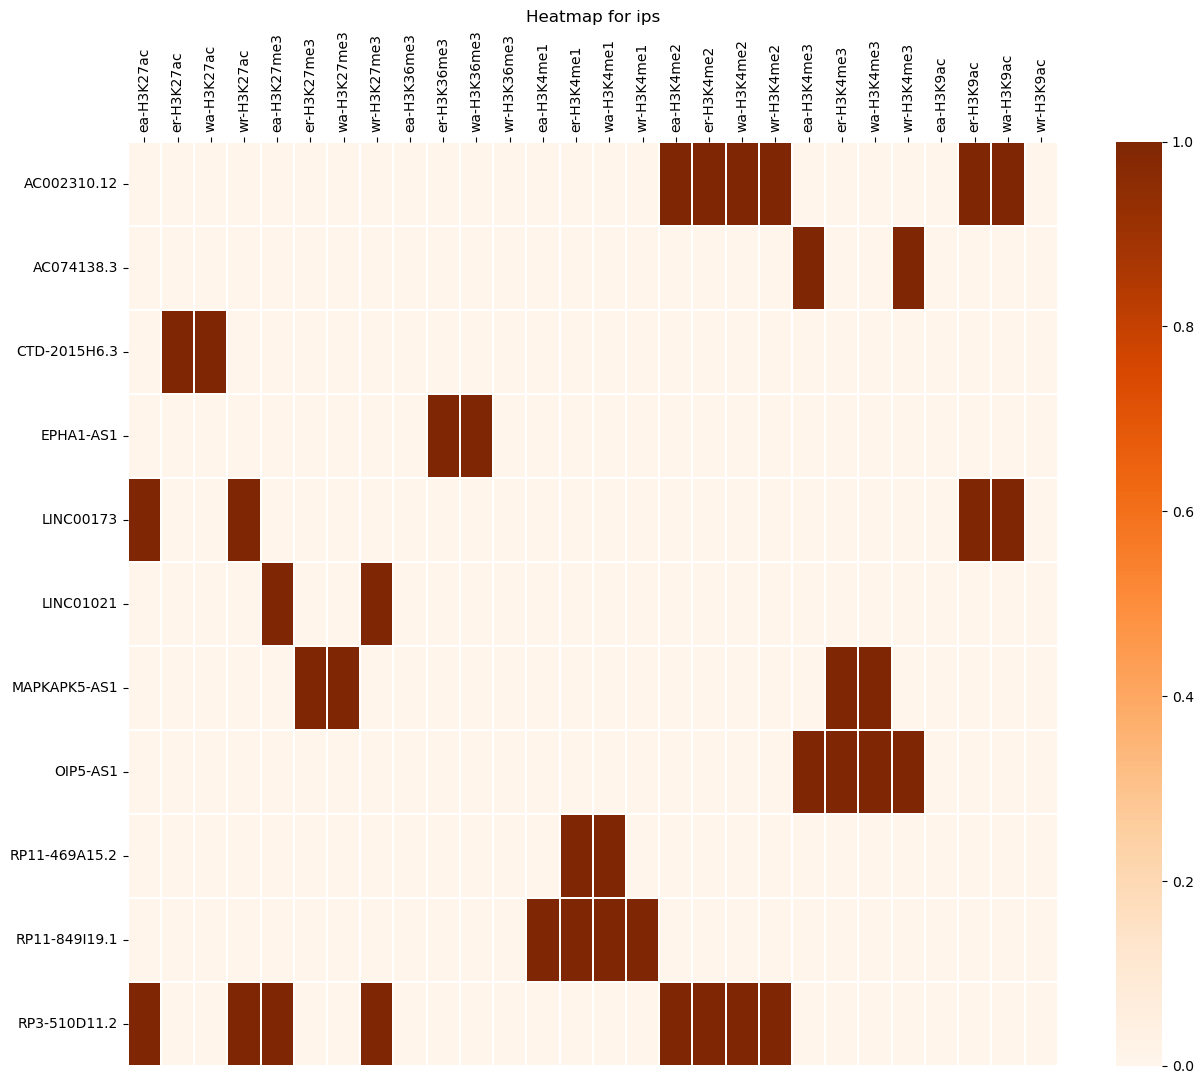

In [658]:
heatmap(fisher_results_filt_by_exp["ips"], "ips")

In [826]:
def heatmap_pval(df, exp):
    df["lnc_aso"] = df["lnc"] + "_" + df["aso"]
    df_for_heatmap = pd.pivot_table(data=df[["hm","lnc_aso","er","ea","wa","wr"]], index=["lnc_aso"], columns="hm", aggfunc=lambda x: -np.log10(x+1e-10))
    fig, ax = plt.subplots(1, 1, figsize=(24, 16), sharey=True)
    heatmap = sns.heatmap(df_for_heatmap.sort_index(axis=1, level=1), linewidths=.3, cmap='Oranges').set_title(f"Heatmap for {exp} (np.log2(p-values))")
    ax.set(xlabel="", ylabel="")
    ax.xaxis.tick_top()
    plt.xticks(rotation=90)
    plt.savefig(IMAGES / f"heatmap_pval_{exp}.png")
    plt.show()

In [1159]:
def heatmap_pval(df, exp):
    df["lnc_aso"] = df["lnc"] + "_" + df["aso"]
    df_for_heatmap = pd.pivot_table(
        data=df[["hm", "lnc_aso", "er", "ea", "wa", "wr"]],
        index=["lnc_aso"],
        columns="hm",
        aggfunc=lambda x: -np.log10(x + 1e-10)
    )

    fig, ax = plt.subplots(1, 1, figsize=(24, 16), sharey=True)
    
    # Нормализация значений для цветовой шкалы
    norm = Normalize(vmin=1, vmax=1.7)
    
    heatmap = sns.heatmap(
        df_for_heatmap.sort_index(axis=1, level=1),
        linewidths=.3,
        cmap='Oranges',
        norm=norm,
        cbar_kws={'ticks': [1, 1.3, df_for_heatmap.max().max()]}
    )
    
    heatmap.set_title(f"Heatmap for {exp} (-np.log10(p-values))")
    ax.set(xlabel="", ylabel="")
    ax.xaxis.tick_top()
    plt.xticks(rotation=90)

    # Добавляем линию и текст на значение 1.3 на цветовой шкале
    colorbar = heatmap.collections[0].colorbar
    colorbar.ax.axhline(1.3, color='red', linewidth=2)
    colorbar.ax.text(2.6, 1.28, '-log10(pval=0.05)', color='black', ha='center', va='center')

    plt.savefig(IMAGES / f"heatmap_pval_{exp}.png")
    plt.show()

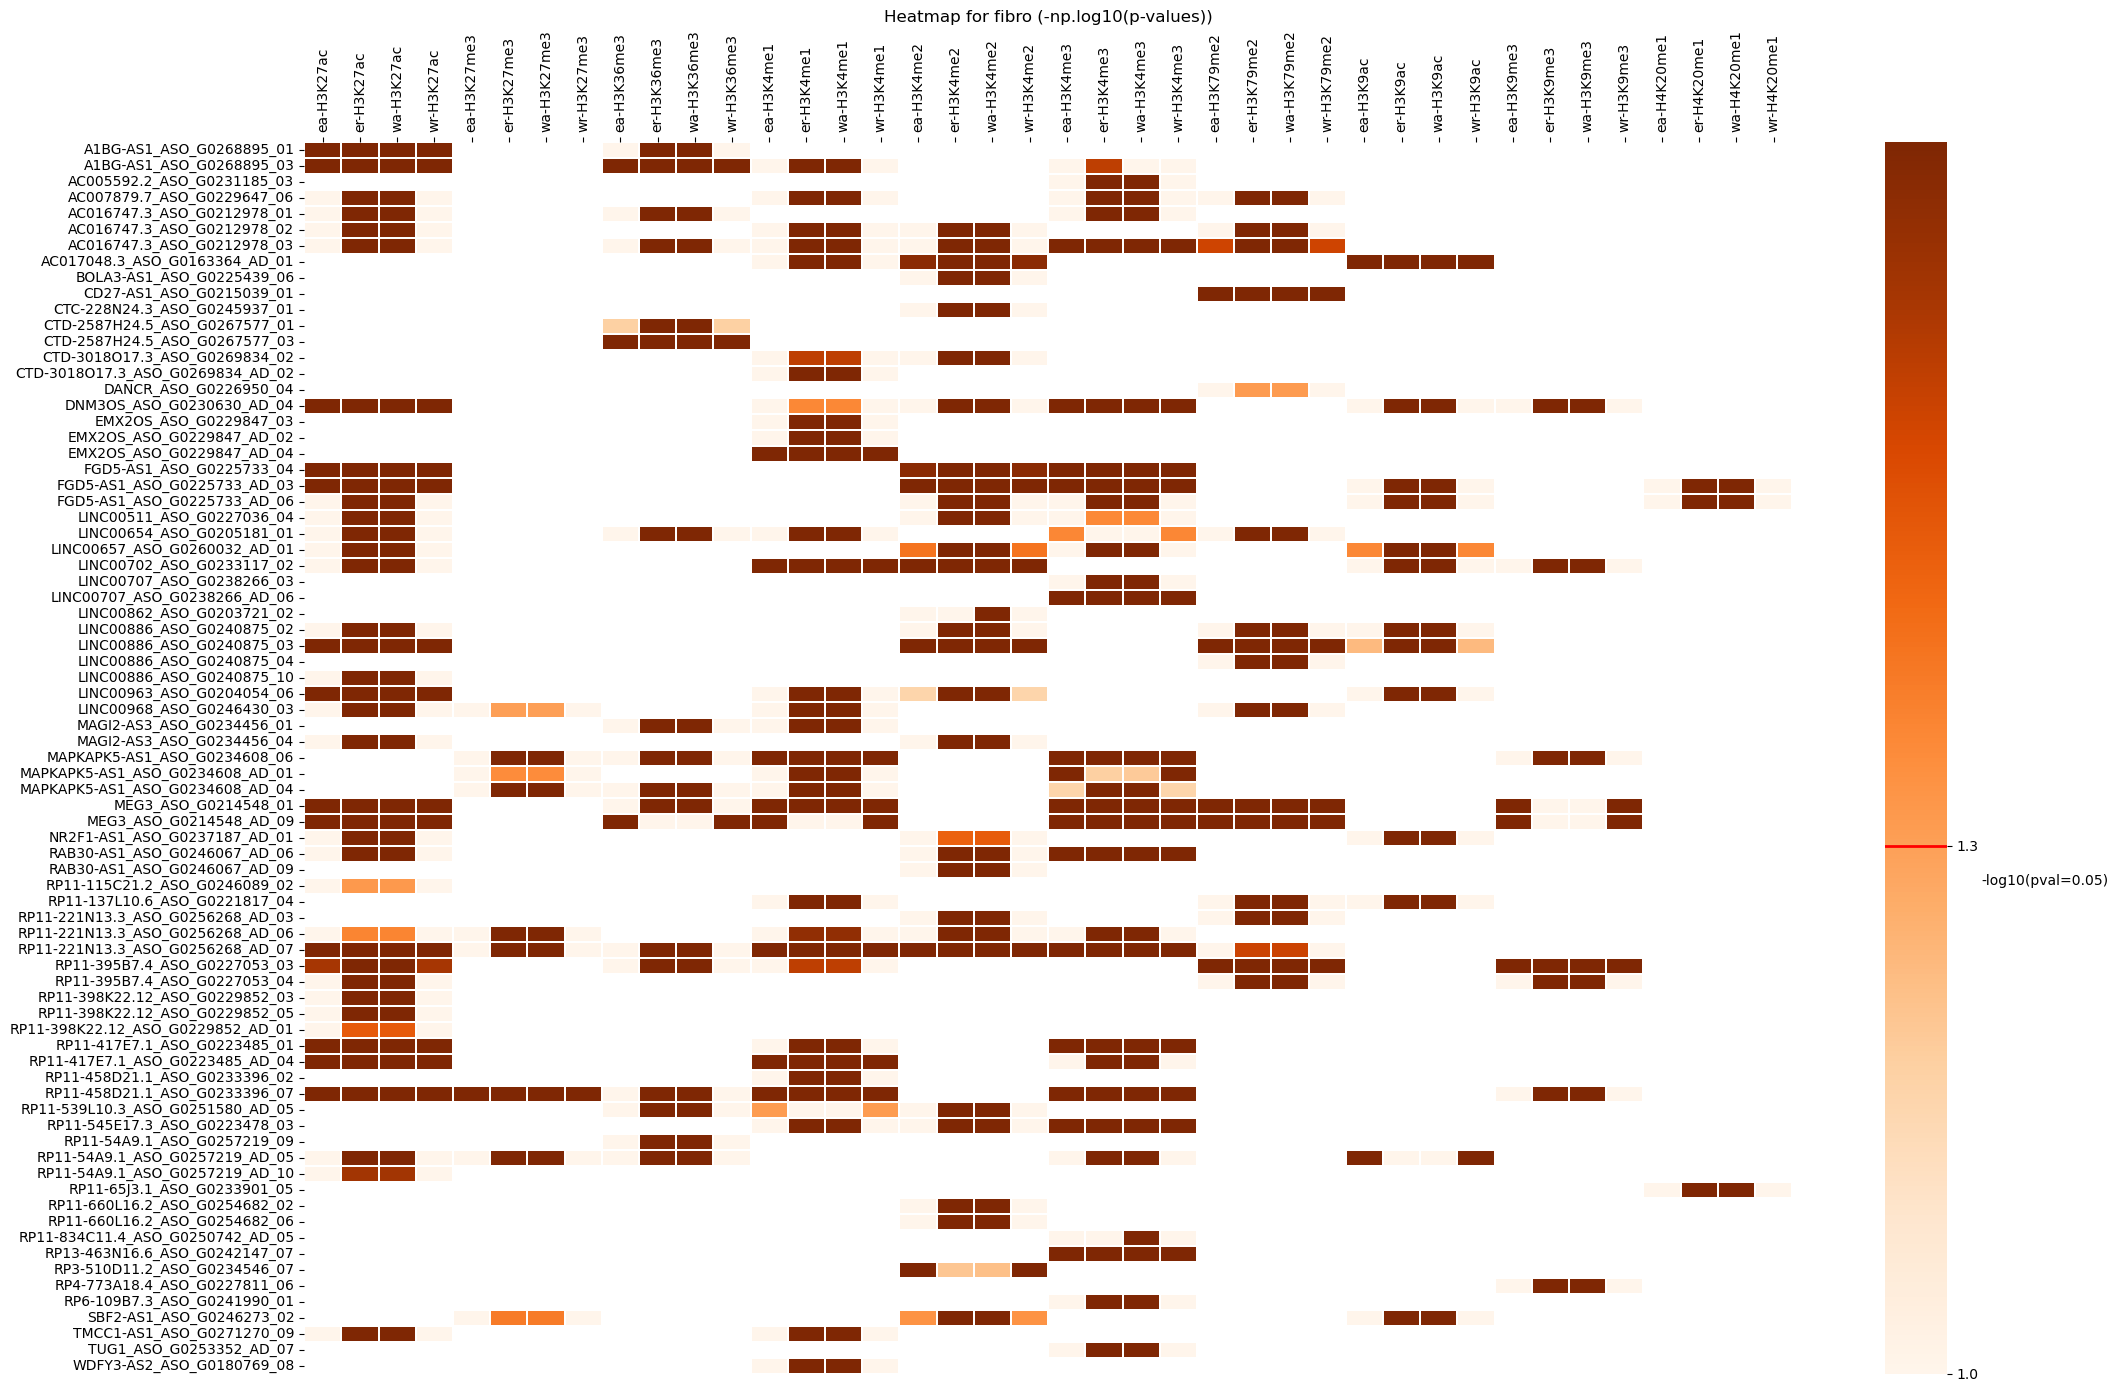

In [1160]:
from matplotlib.colors import Normalize
heatmap_pval(fisher_results_filt_by_exp["fibro"], "fibro")

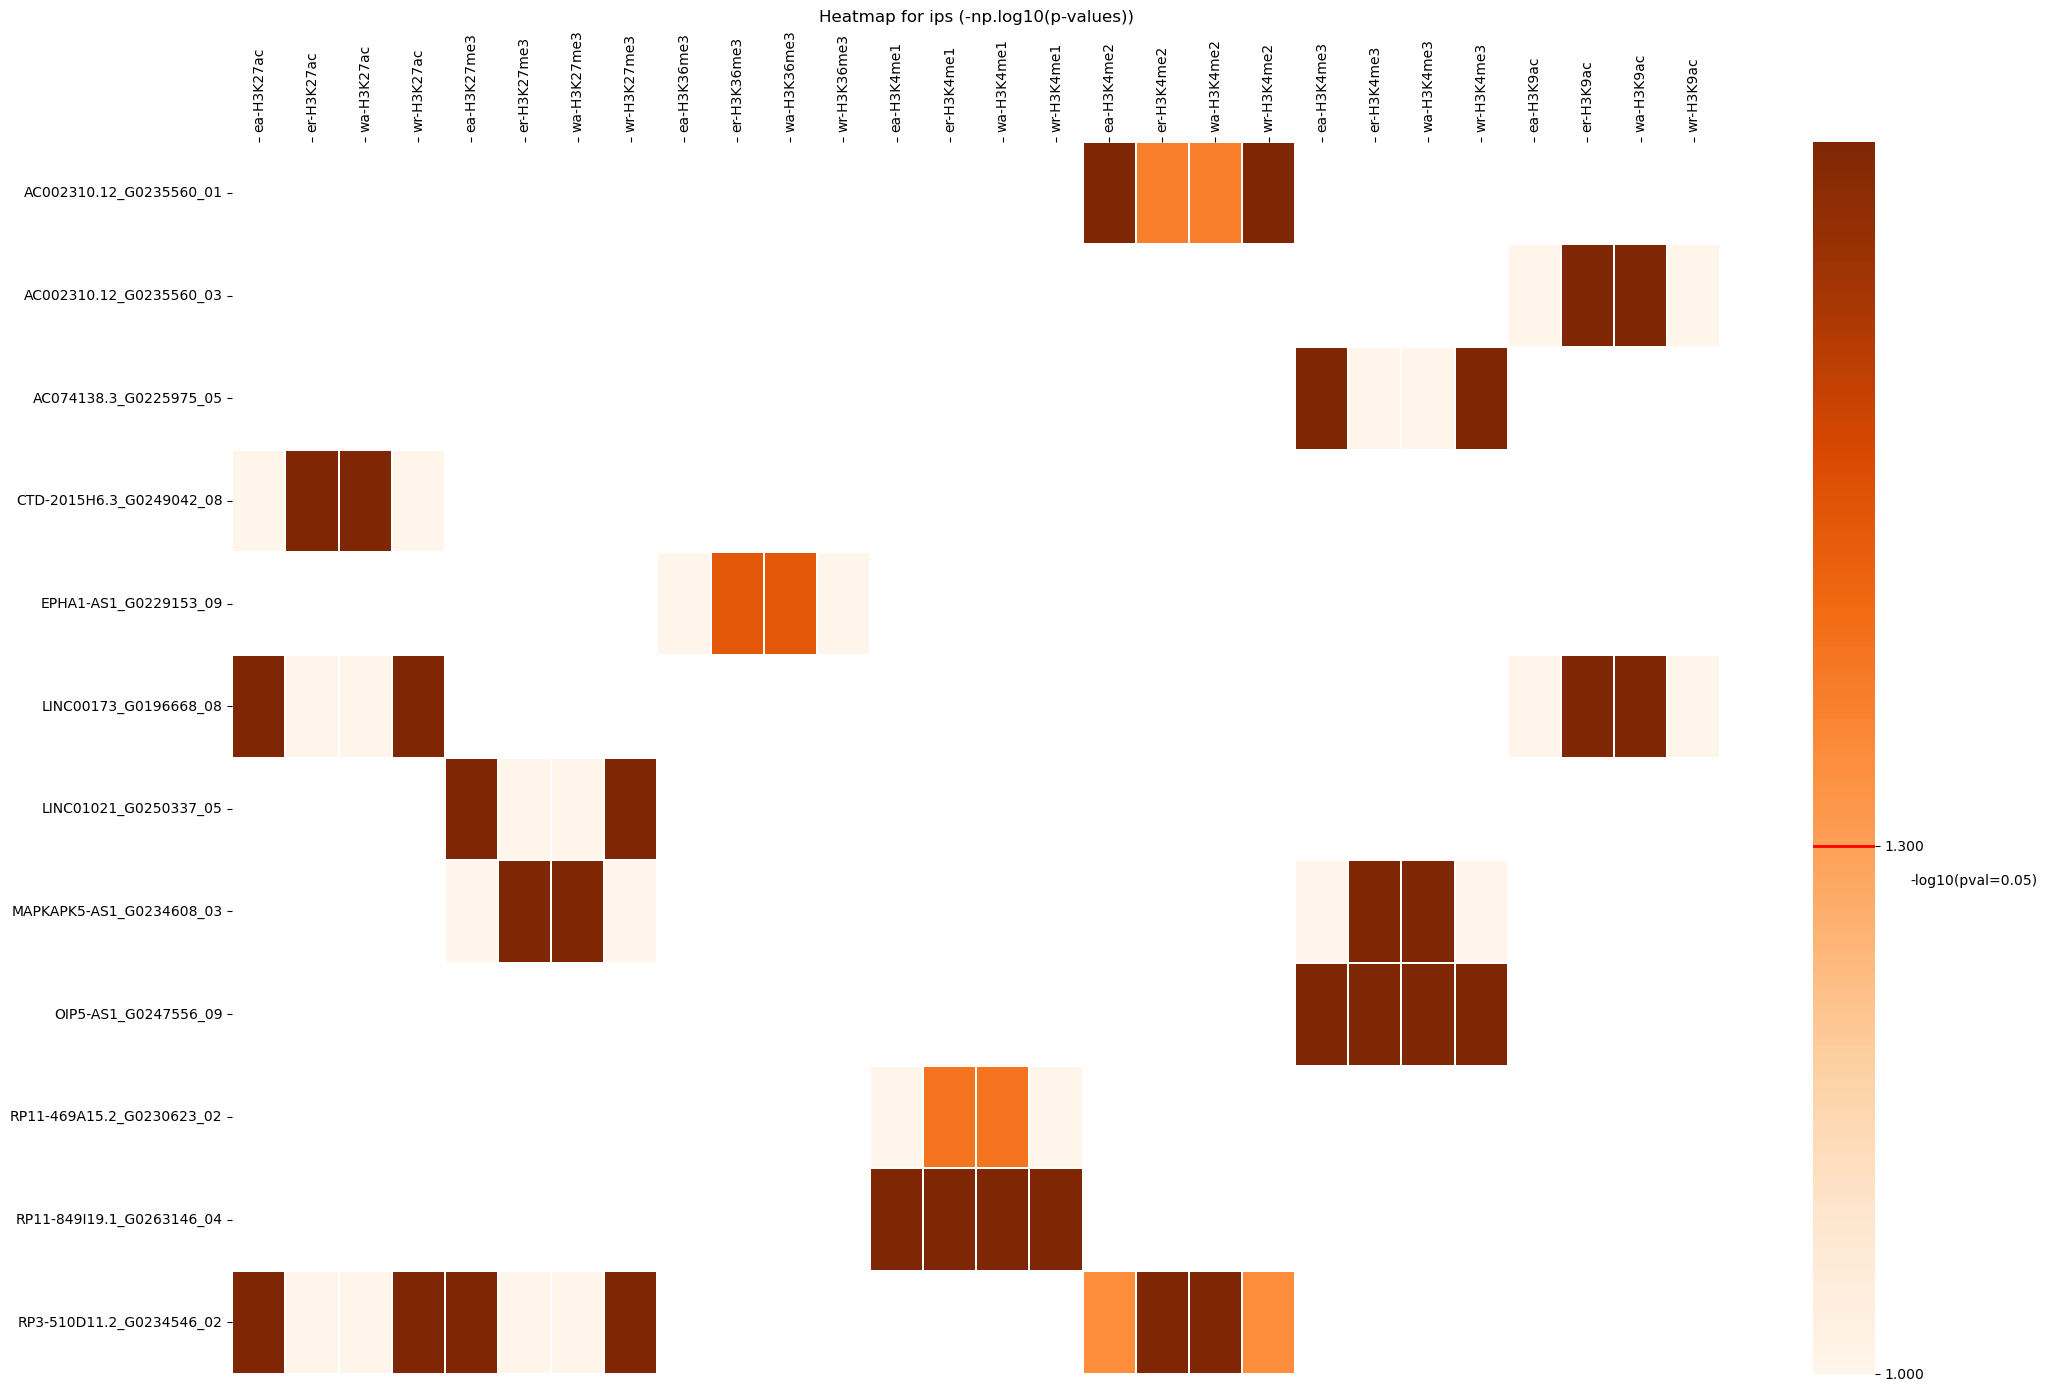

In [1162]:
from matplotlib.colors import Normalize
heatmap_pval(fisher_results_filt_by_exp["ips"], "ips")

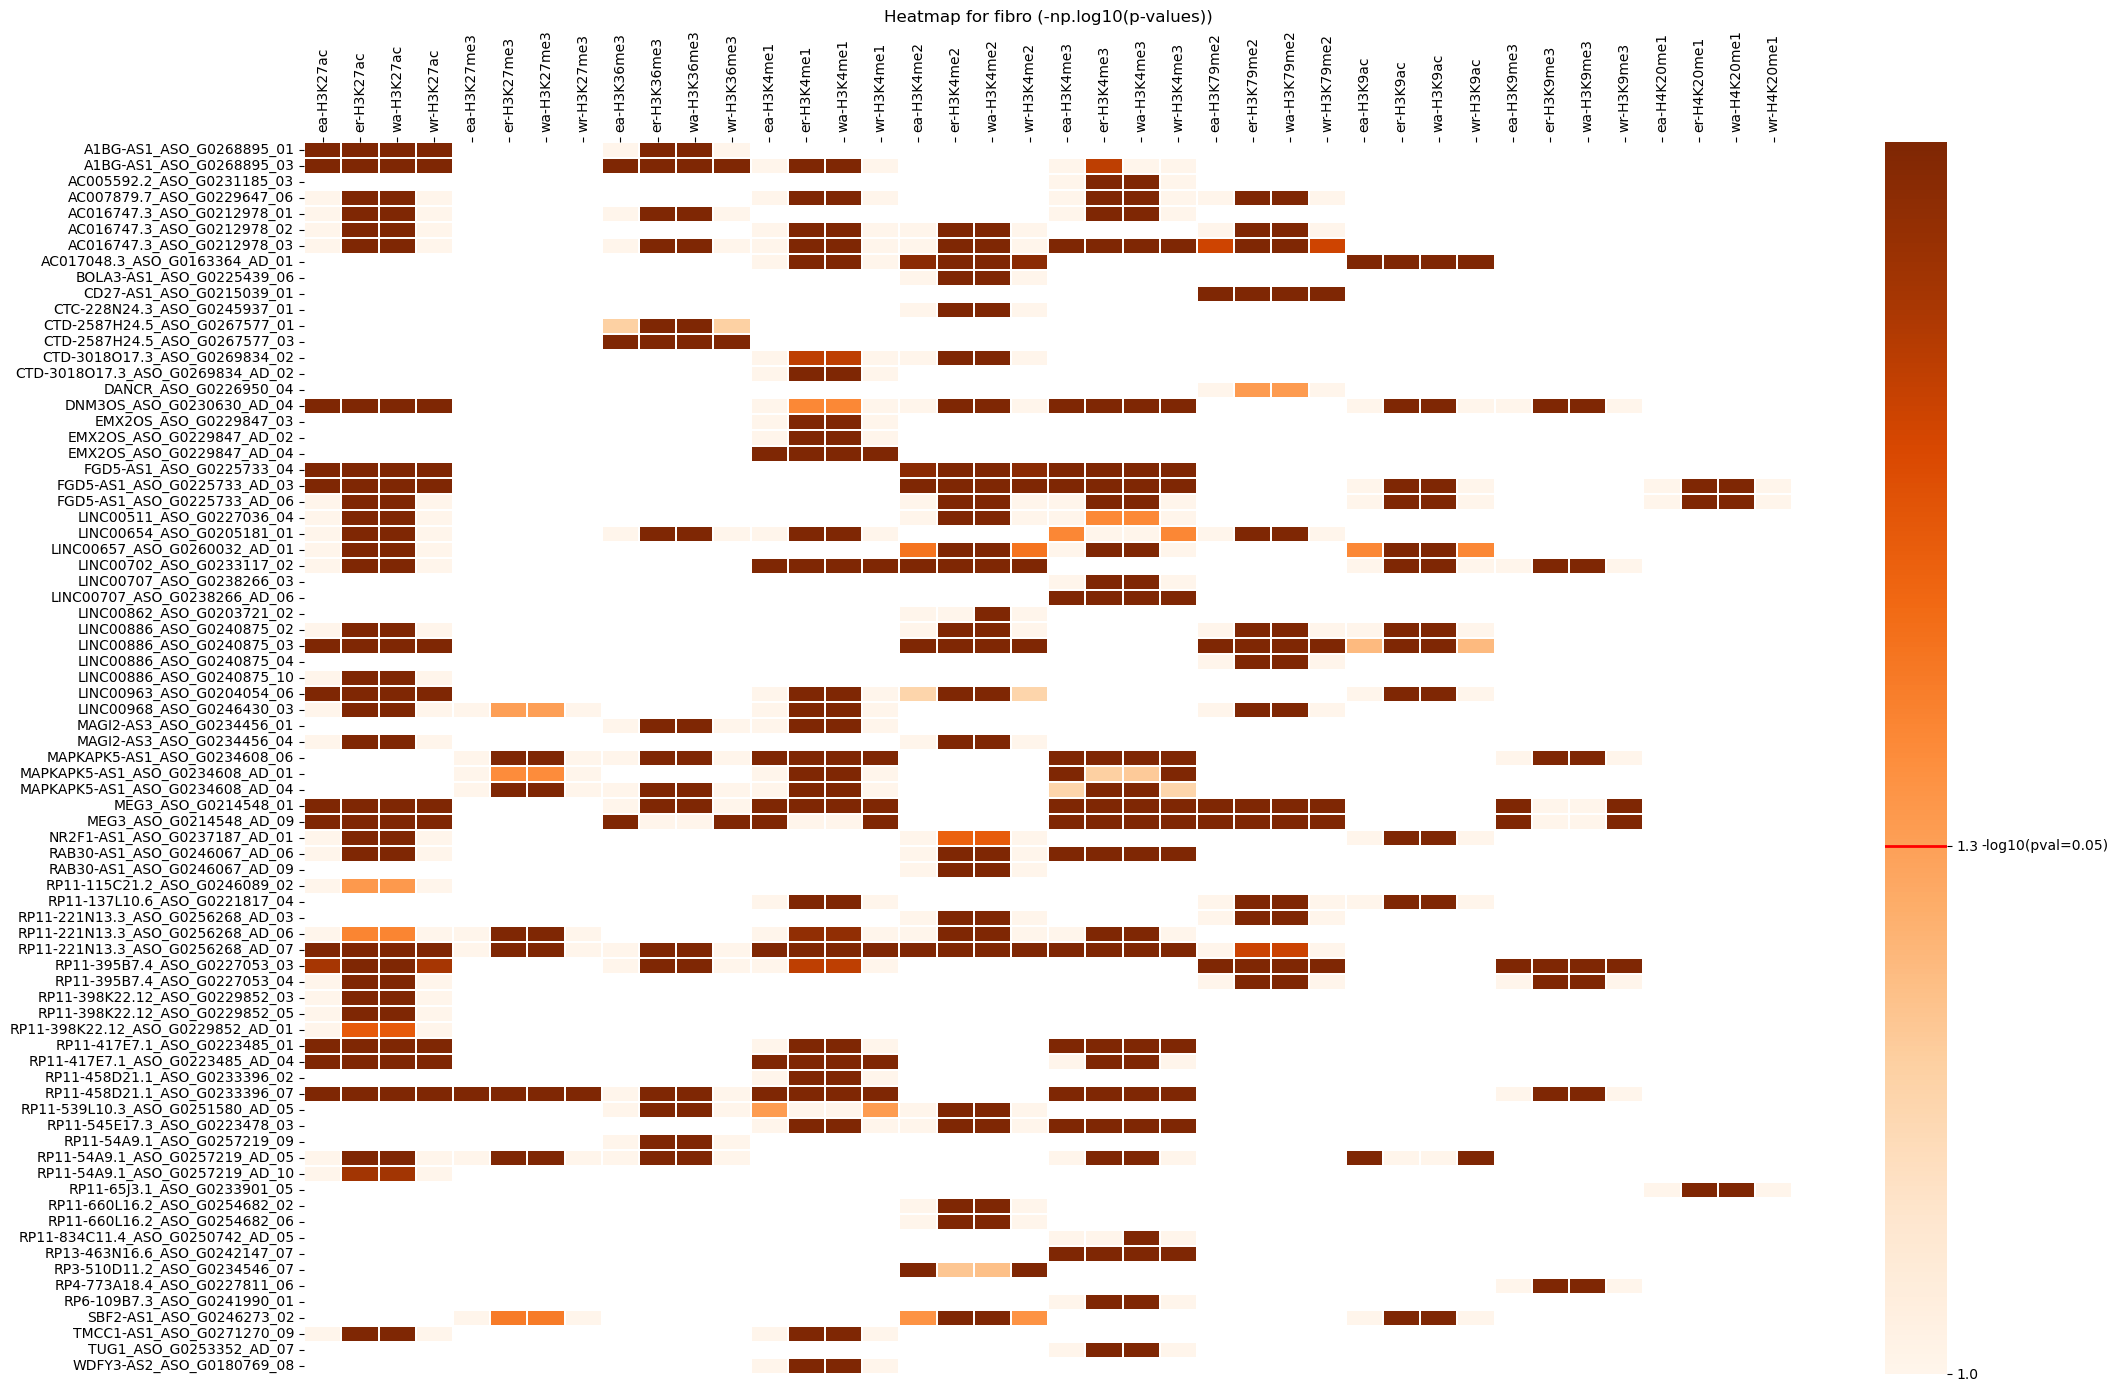

In [1146]:
heatmap_pval(fisher_results_filt_by_exp["fibro"], "fibro")

In [866]:
df_for_heatmap = pd.pivot_table(
        data=fisher_results_filt_by_exp["fibro"][["hm", "lnc_aso", "er", "ea", "wa", "wr"]],
        index=["lnc_aso"],
        columns="hm",
    ).sort_index(axis=1, level=1)

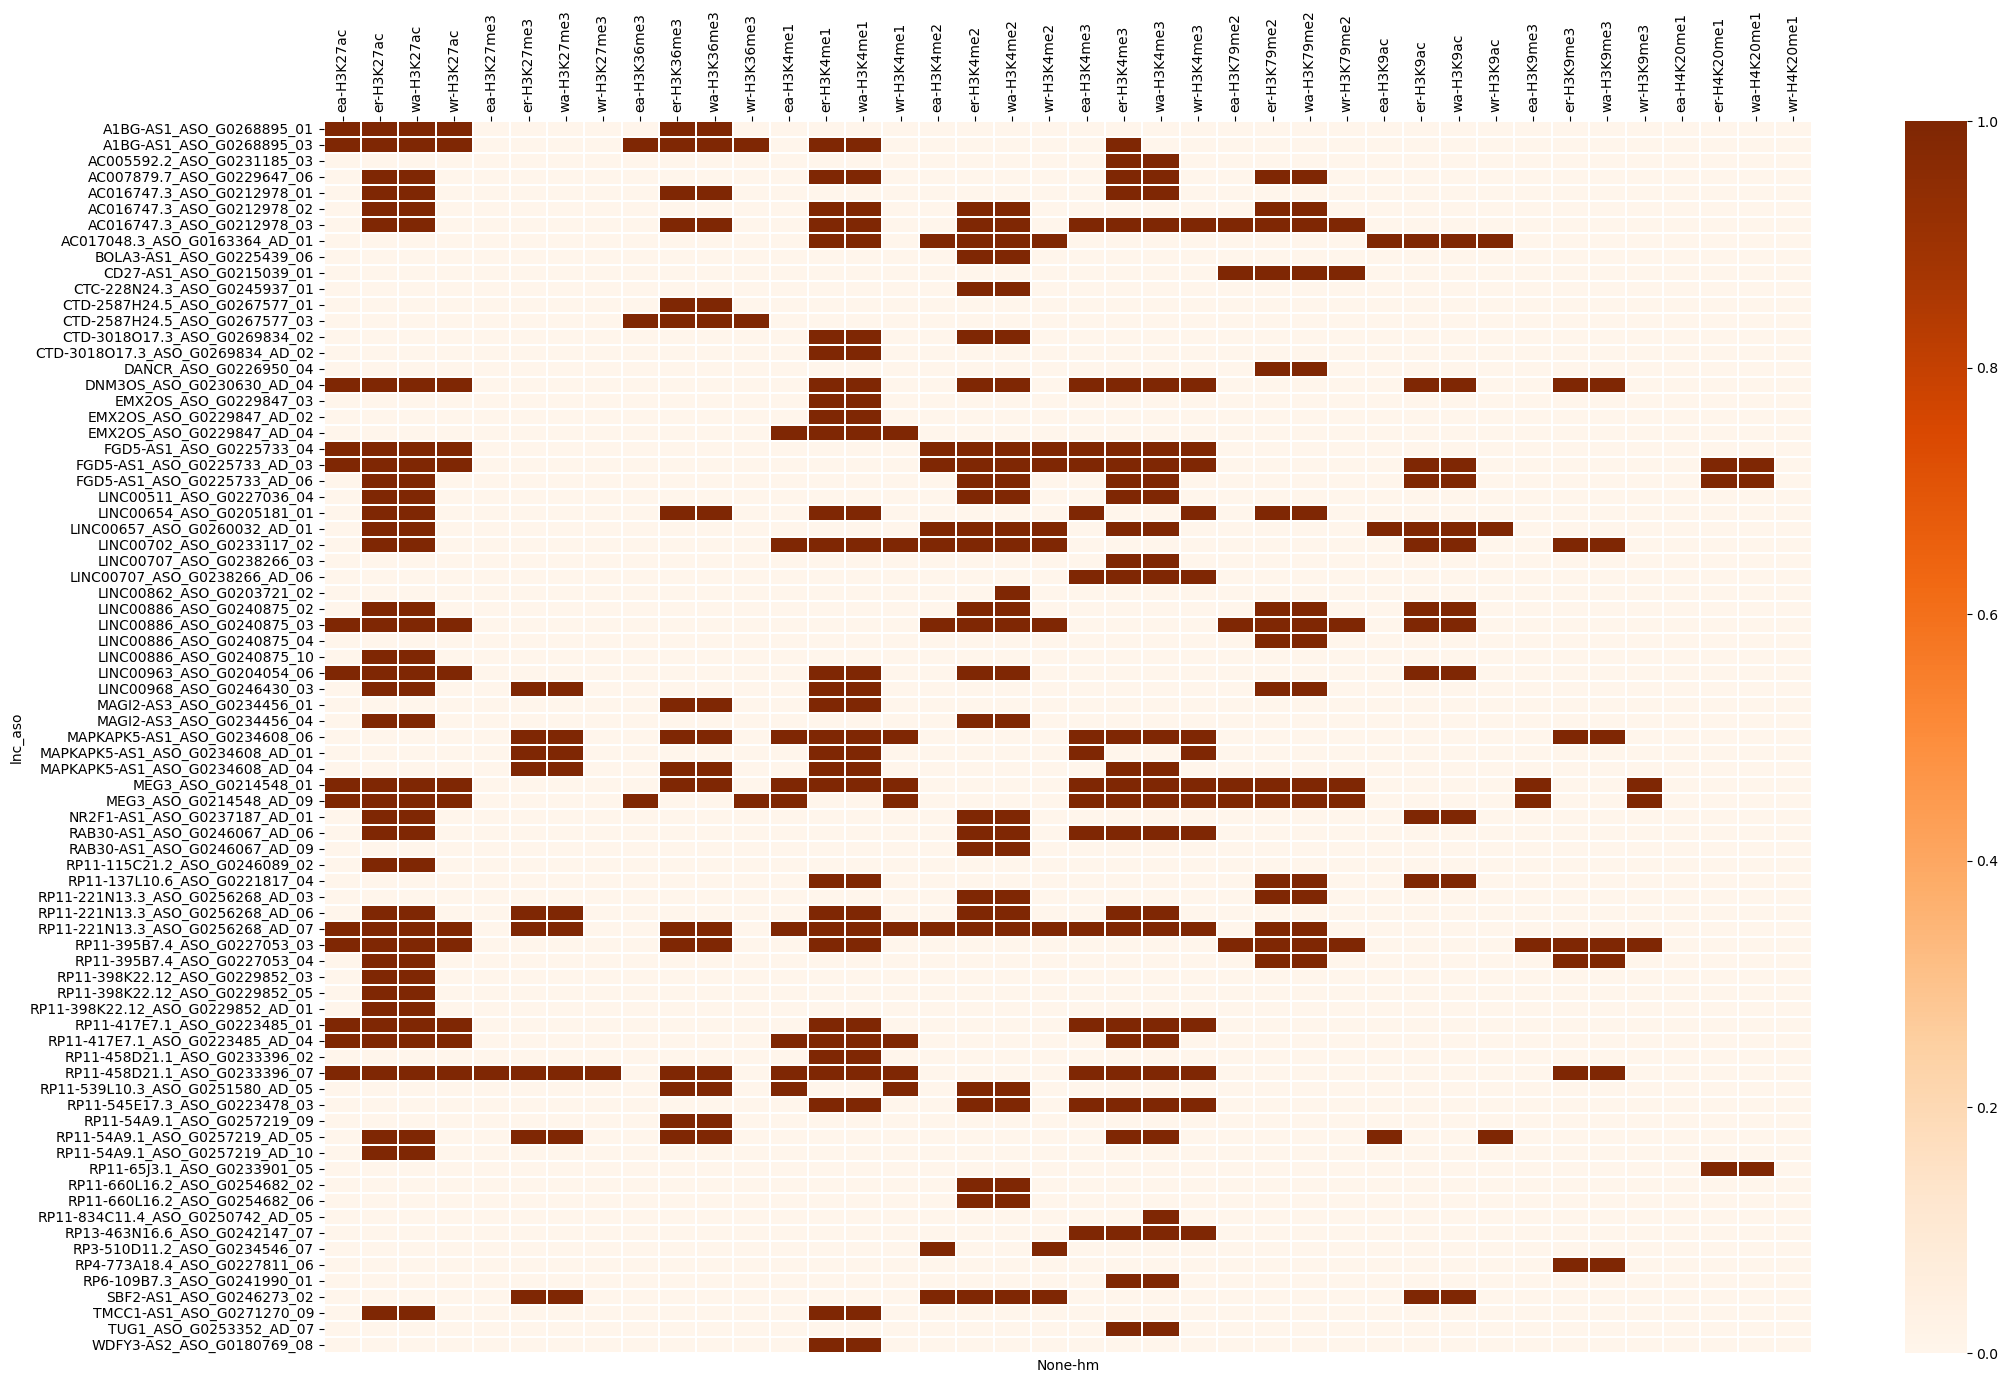

In [882]:
fig, ax = plt.subplots(1, 1, figsize=(24, 16), sharey=True)

heatmap = sns.heatmap(
    (df_for_heatmap < 0.05).sort_index(axis=1, level=1),
    linewidths=.3,
    cmap='Oranges'
)
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.show()

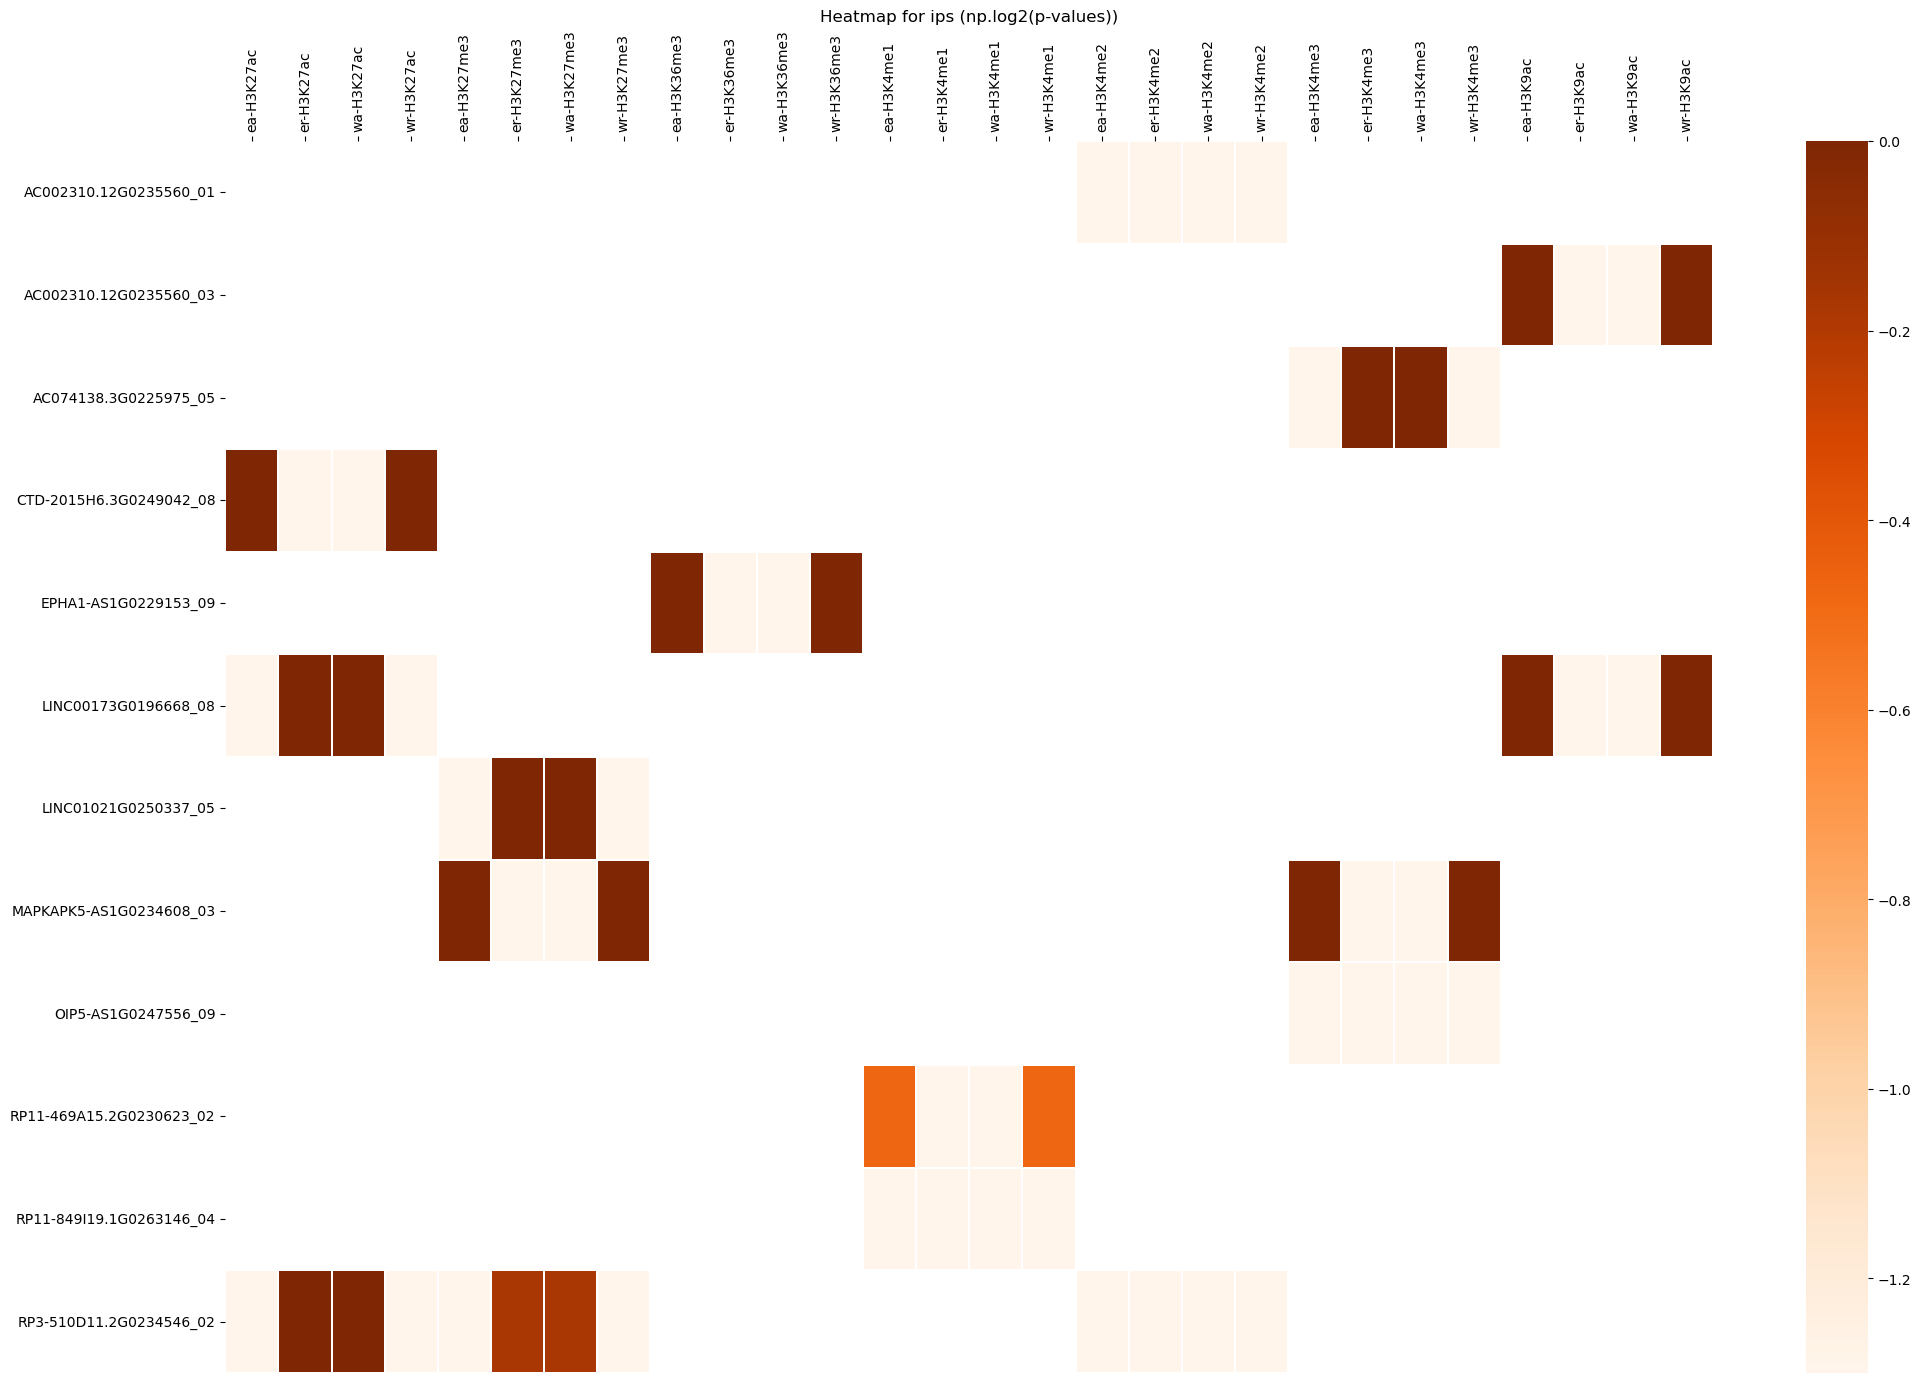

In [744]:
heatmap_pval(fisher_results_filt_by_exp["ips"], "ips")

In [676]:
fibro_pvalue_heatmap = fisher_results_filt_by_exp["fibro"]
fibro_pvalue_heatmap

,hm,lnc_ens,aso,er,ea,wa,wr,lnc
12,H4K20me1,ENSG00000225733,ASO_G0225733_AD_03,9.428572e-04,1.000000e+00,9.428572e-04,1.000000e+00,FGD5-AS1
13,H4K20me1,ENSG00000225733,ASO_G0225733_AD_06,2.566966e-03,1.000000e+00,2.566966e-03,1.000000e+00,FGD5-AS1
31,H4K20me1,ENSG00000233901,ASO_G0233901_05,2.566966e-03,1.000000e+00,2.566966e-03,1.000000e+00,RP11-65J3.1
127,H3K27me3,ENSG00000233396,ASO_G0233396_07,3.227482e-88,2.460891e-15,3.227482e-88,2.460891e-15,RP11-458D21.1
138,H3K27me3,ENSG00000234608,ASO_G0234608_06,1.384337e-70,1.991006e-01,1.384337e-70,1.991006e-01,MAPKAPK5-AS1
...,...,...,...,...,...,...,...,...
946,H3K79me2,ENSG00000240875,ASO_G0240875_03,1.429075e-07,1.116124e-03,1.429075e-07,1.116124e-03,LINC00886
947,H3K79me2,ENSG00000240875,ASO_G0240875_04,7.964055e-03,1.000000e+00,7.964055e-03,1.000000e+00,LINC00886
956,H3K79me2,ENSG00000246430,ASO_G0246430_03,6.331531e-04,2.560905e-01,6.331531e-04,2.560905e-01,LINC00968
966,H3K79me2,ENSG00000256268,ASO_G0256268_AD_03,6.372911e-03,1.000000e+00,6.372911e-03,1.000000e+00,RP11-221N13.3


In [684]:
np.log2(fibro_pvalue_heatmap[["er", "ea", "wa", "wr"]])

/home/magletdinov/mambaforge/envs/work/lib/python3.9/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


,er,ea,wa,wr
12,-10.050673,0.000000,-10.050673,0.000000
13,-8.605720,0.000000,-8.605720,0.000000
31,-8.605720,0.000000,-8.605720,0.000000
127,-290.639263,-48.529741,-290.639263,-48.529741
138,-232.065771,-2.328431,-232.065771,-2.328431
...,...,...,...,...
946,-22.738416,-9.807287,-22.738416,-9.807287
947,-6.972281,0.000000,-6.972281,0.000000
956,-10.625158,-1.965274,-10.625158,-1.965274
966,-7.293832,0.000000,-7.293832,0.000000


In [691]:
fibro_pvalue_heatmap["lnc_aso"] = fibro_pvalue_heatmap["lnc"] + fibro_pvalue_heatmap["aso"]

In [737]:
df_for_heatmap = pd.pivot_table(data=fibro_pvalue_heatmap[["hm","lnc_aso","er","ea","wa","wr"]], index=["lnc_aso"], columns="hm", aggfunc=np.log2)
df_for_heatmap.sort_index(axis=1, level=1)

/home/magletdinov/mambaforge/envs/work/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ea,er,wa,wr,ea,er,wa,wr,ea,er,...,wa,wr,ea,er,wa,wr,ea,er,wa,wr
hm,H3K27ac,H3K27ac,H3K27ac,H3K27ac,H3K27me3,H3K27me3,H3K27me3,H3K27me3,H3K36me3,H3K36me3,...,H3K9ac,H3K9ac,H3K9me3,H3K9me3,H3K9me3,H3K9me3,H4K20me1,H4K20me1,H4K20me1,H4K20me1
lnc_aso,,,,,,,,,,,,,,,,,,,,,
A1BG-AS1ASO_G0268895_01,-7.070949,-86.423320,-86.423320,-7.070949,NaN,NaN,NaN,NaN,0.000000,-42.365201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1BG-AS1ASO_G0268895_03,-39.847997,-411.162454,-411.162454,-39.847997,NaN,NaN,NaN,NaN,-16.674936,-26.288332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC005592.2ASO_G0231185_03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC007879.7ASO_G0229647_06,0.000000,-16.258488,-16.258488,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC016747.3ASO_G0212978_01,0.000000,-28.641978,-28.641978,0.000000,NaN,NaN,NaN,NaN,0.000000,-5.652947,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP6-109B7.3ASO_G0241990_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SBF2-AS1ASO_G0246273_02,NaN,NaN,NaN,NaN,0.0,-4.627864,-4.627864,0.0,NaN,NaN,...,-9.601243,-0.001897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


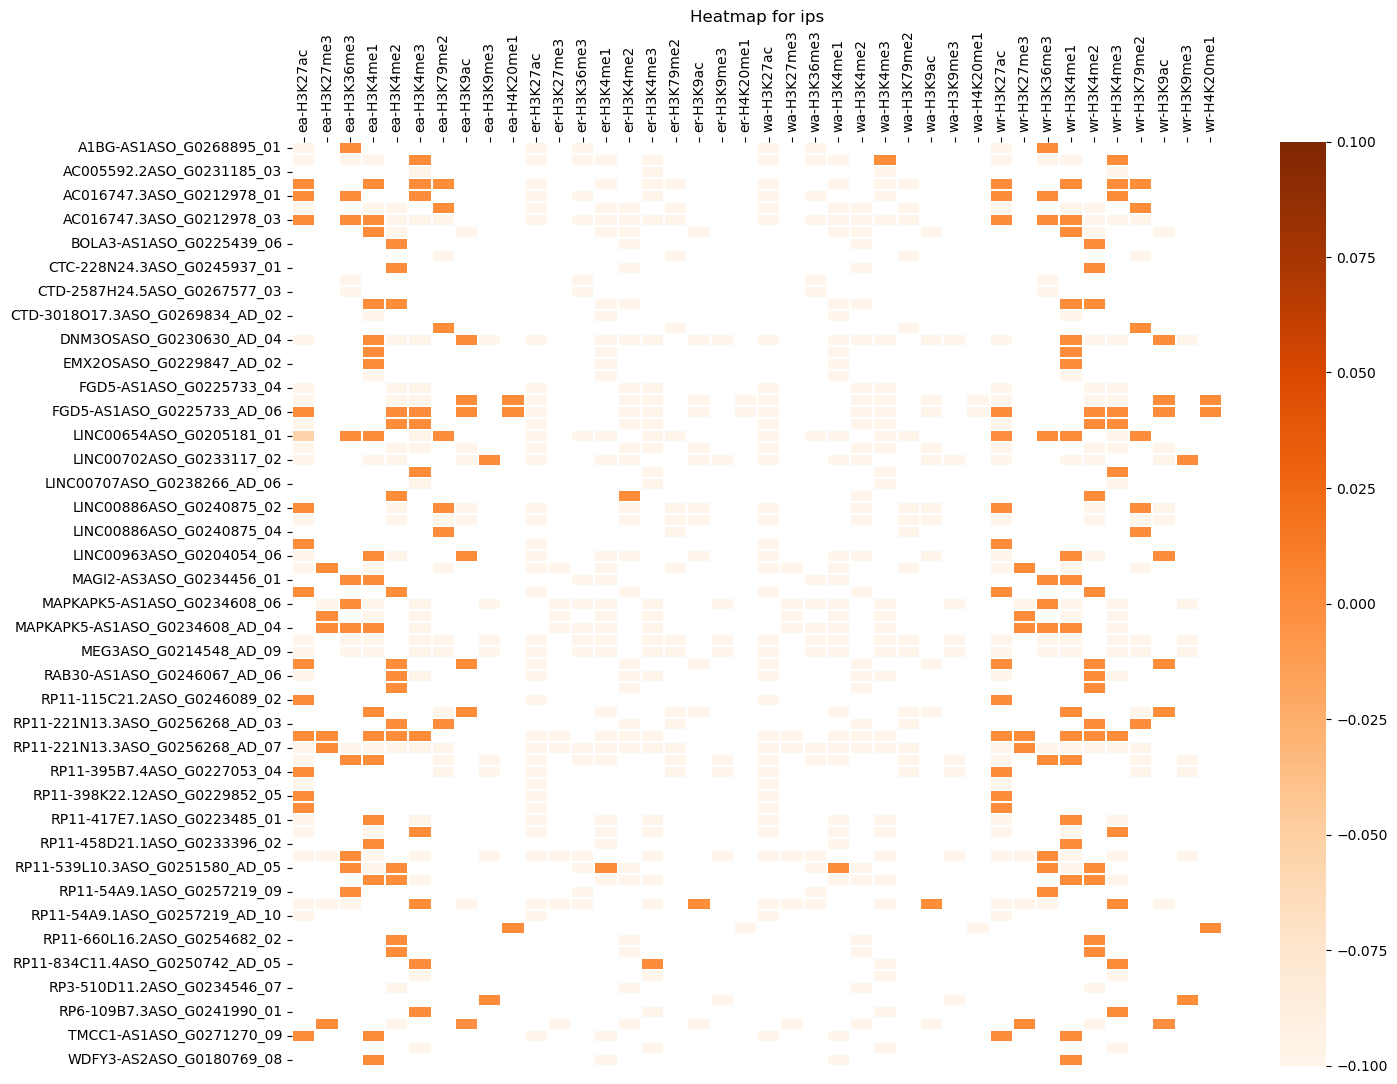

In [716]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12), sharey=True)
heatmap = sns.heatmap(df_for_heatmap, linewidths=.3, cmap='Oranges', annot=False).set_title(f"Heatmap for {exp}")
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.show()    

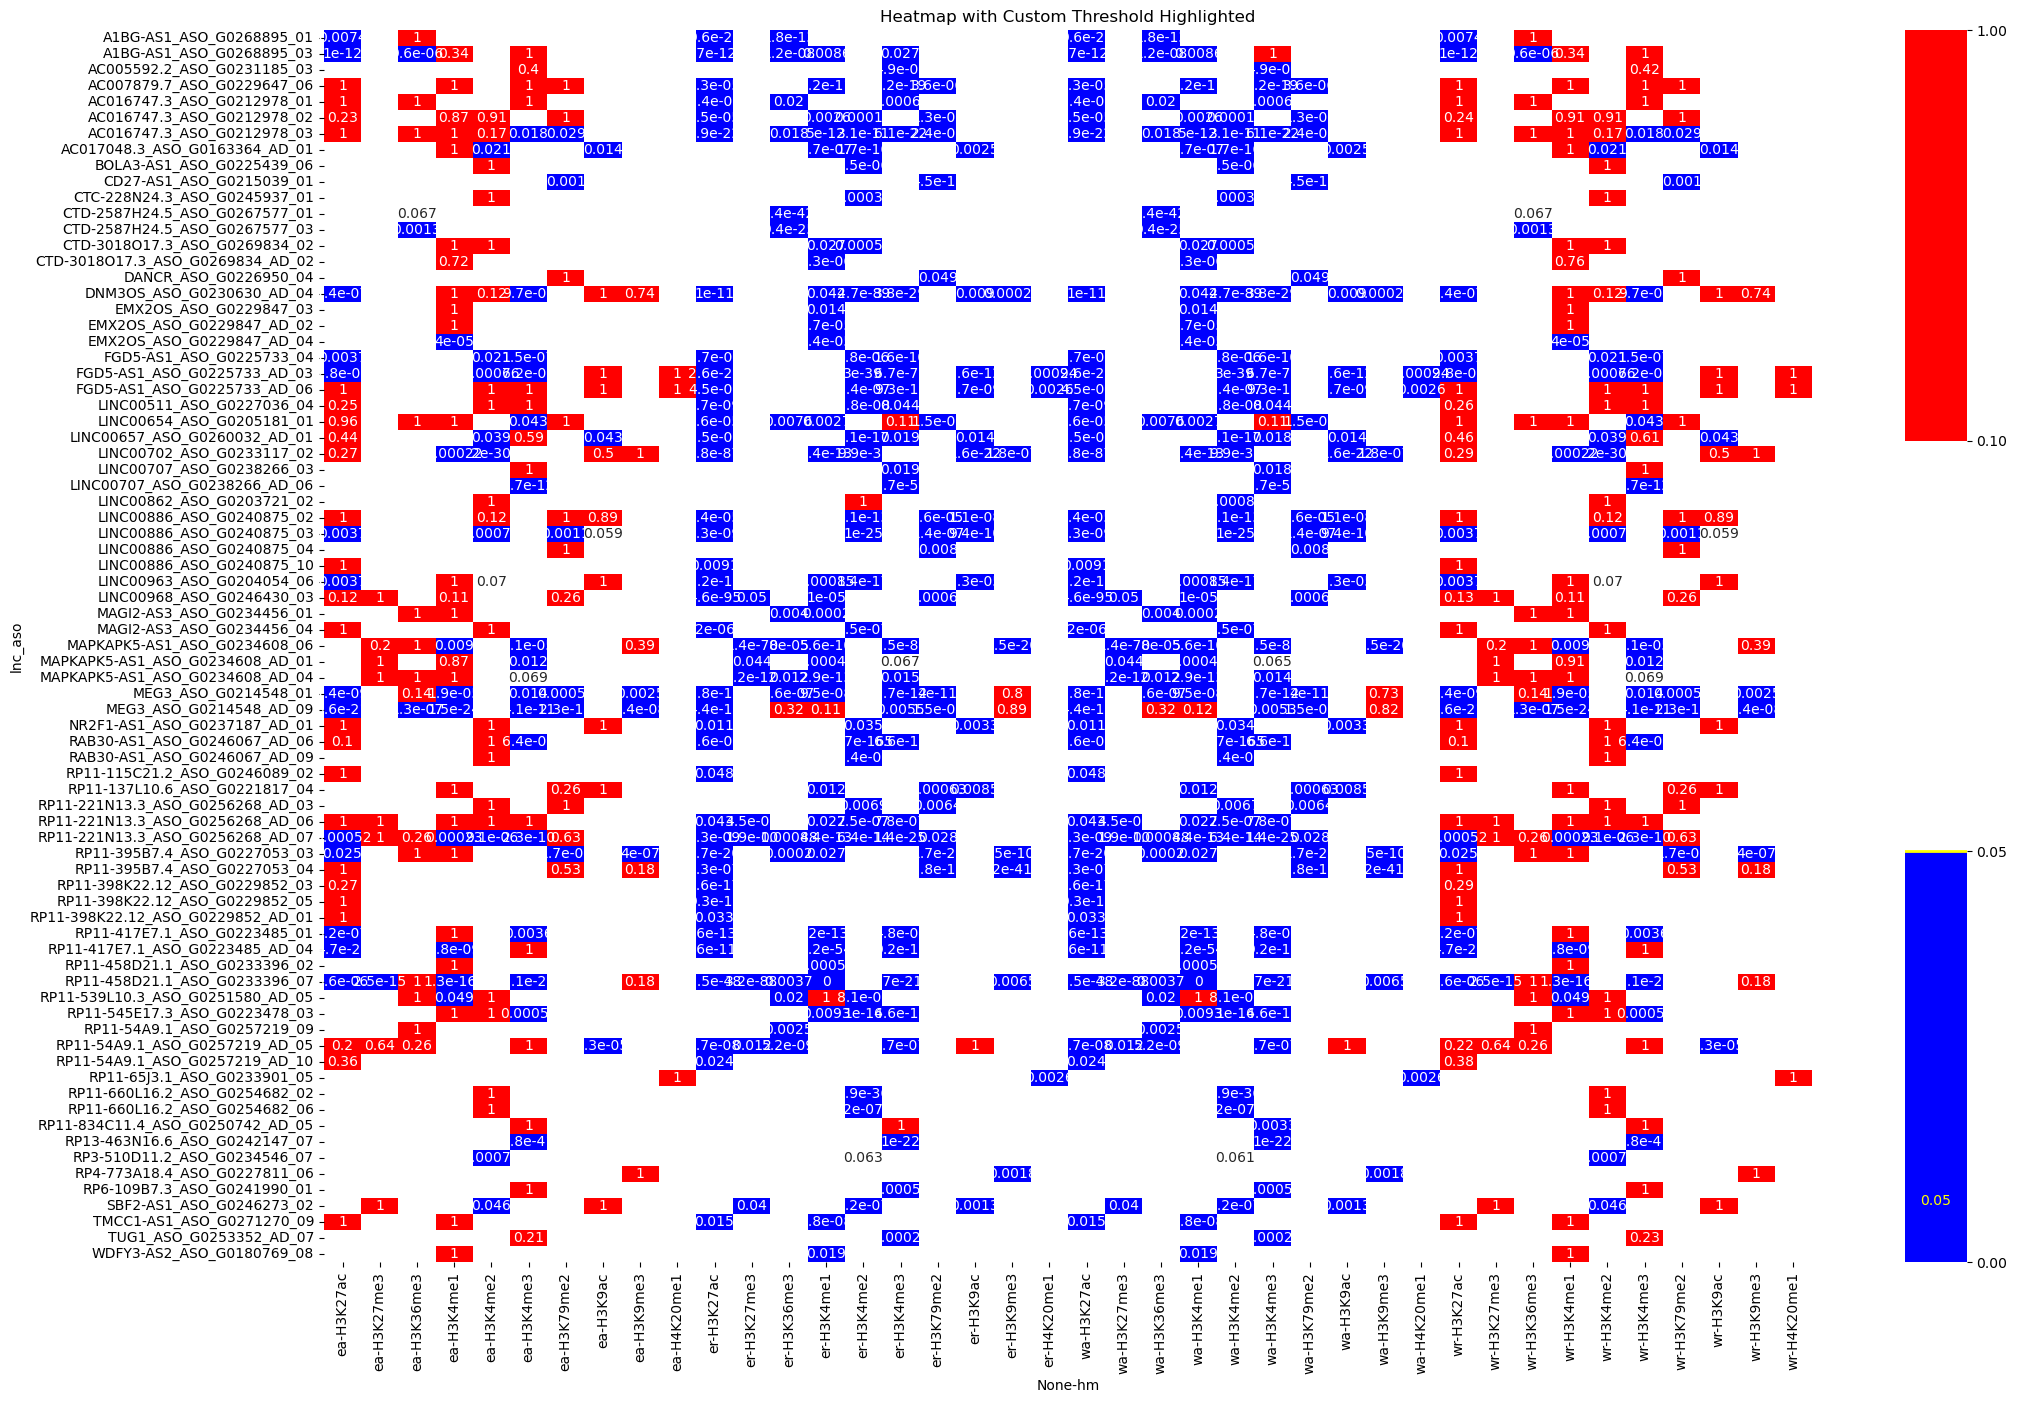

In [806]:
cmap = ListedColormap(['blue', 'white', 'red'])
bounds = [0, 0.05, 0.1, 1]
norm = BoundaryNorm(bounds, cmap.N)

# Рисуем тепловую карту
plt.figure(figsize=(24, 16))
df_for_heatmap = pd.pivot_table(data=fisher_results_filt_by_exp["fibro"][["hm","lnc_aso","er","ea","wa","wr"]], index=["lnc_aso"], columns="hm")
heatmap = sns.heatmap(df_for_heatmap, cmap=cmap, norm=norm, annot=True, cbar_kws={'boundaries': bounds, 'ticks': [0, 0.05, 0.1, 1]})

# Добавляем пороговое значение на легенду
colorbar = heatmap.collections[0].colorbar
colorbar.ax.axhline(0.05, color='yellow', linewidth=2)
colorbar.ax.text(0.5, 0.05, '0.05', color='yellow', ha='center', va='center', transform=colorbar.ax.transAxes)

plt.title('Heatmap with Custom Threshold Highlighted')
plt.show()

In [ ]:
# Добавляем пороговое значение на легенду
colorbar = heatmap.collections[0].colorbar
colorbar.ax.axhline(0.05, color='yellow', linewidth=2)
colorbar.ax.text(0.5, 0.05, '0.05', color='yellow', ha='center', va='center', transform=colorbar.ax.transAxes)

plt.title('Heatmap with Custom Threshold Highlighted')
plt.show()

## Pubmed

In [41]:
# Установка адреса электронной почты, необходимого для использования API PubMed
Entrez.email = "m.agletdinov2018@gmail.com"

def search_pubmed(query):
    # Поиск статей по запросу
    handle = Entrez.esearch(db="pubmed", term=query, retmax=10)
    record = Entrez.read(handle)
    handle.close()
    return record

def fetch_abstract(pmid):
    # Получение абстракта статьи по ее PubMed ID (PMID)
    handle = Entrez.efetch(db="pubmed", id=pmid, rettype="abstract", retmode="text")
    abstract = handle.read()
    handle.close()
    return abstract.replace("\n","")

pubmed_res = defaultdict(list)
for query in fisher_results_filt["lnc"].unique():
    print(f"{query}\n")
    record = search_pubmed(query)
    for pmid in record["IdList"]:
        abstract = fetch_abstract(pmid)
        print("\tPubMed ID:", pmid)
        pubmed_res[query].append([pmid, abstract])

RP3-510D11.2

MAPKAPK5-AS1

	PubMed ID: 38846329
	PubMed ID: 38225924
	PubMed ID: 37154079
	PubMed ID: 36867352
	PubMed ID: 36567178
	PubMed ID: 36510238
	PubMed ID: 36445573
	PubMed ID: 36379256
	PubMed ID: 36009801
	PubMed ID: 35674862
LINC01021

	PubMed ID: 38730591
	PubMed ID: 36342127
	PubMed ID: 35173309
	PubMed ID: 35012438
	PubMed ID: 34469433
	PubMed ID: 34026327
	PubMed ID: 32774710
	PubMed ID: 32774475
	PubMed ID: 29262524
	PubMed ID: 28877474
RP1-46F2.2

EPHA1-AS1

	PubMed ID: 38003532
	PubMed ID: 33516273
RP11-421L21.3

LINC00173

	PubMed ID: 38705575
	PubMed ID: 38182665
	PubMed ID: 38069335
	PubMed ID: 37365917
	PubMed ID: 37258811
	PubMed ID: 37081063
	PubMed ID: 36894691
	PubMed ID: 36856154
	PubMed ID: 36774758
	PubMed ID: 36627670
AC016747.3

	PubMed ID: 34735975
AC002310.12

SBF2-AS1

	PubMed ID: 38279439
	PubMed ID: 37593490
	PubMed ID: 37538086
	PubMed ID: 37445702
	PubMed ID: 37286777
	PubMed ID: 37131869
	PubMed ID: 37072750
	PubMed ID: 36927189
	PubMed ID: 3681

In [42]:
pubmed_res.keys()

dict_keys(['MAPKAPK5-AS1', 'LINC01021', 'EPHA1-AS1', 'LINC00173', 'AC016747.3', 'SBF2-AS1', 'OIP5-AS1', 'AC007255.8', 'AC009299.3', 'LINC00883'])

In [ ]:
# считать попроавку для подслучаев также, как и для всех. По меткам

# 